# -- Multi-FOV 2DVAR surface retrievals w/ real AMSR2 data --

In [1]:
#  David Duncan, Chalmers University, Mar 2019

# this particular version (real1) attempts retrieval from real AMSR2 L1R data
#  over a very limited spatial domain doing 2dvar retrieval of sst/wind


#  this script uses ARTS OEM to experiment with retrieval of a synthetic scene. 
#    the goal here is to probe the spatial resolution of geophysical parameter 
#    that may be retrievable with such a sensor, focused on AMSR2 and surface params

# this setup, in steps/words:
### - define an antenna response that is frequency dependent, gaussian, symmetric
### - define sensor position and line of sight for each scan at middle of scan
### - define an angular grid (zenith & azimuth) for each scan that encompasses npix
### - sensor angles are all 'absolute' whereas the angular grid and antenna response 
###    are all relative to the central bore sight of the scan
### - a lat/lon grid is also defined that must encompass all observation points simulated
### - the same angular grid and simulation setup is assumed/copied for all nscans, and 
###    mblock_dlos_grid allows all simulations to be run at the same time

### *** this setup outputs simulates TBs for chosen channels of AMSR2
###    with antenna patterns taken into account and decoupled from any retrieval grid, with
###    pencil beam calculations sampling the antenna pattern according to the angular grid
###    defined

### a priori covariances are defined in terms of standard deviations and decorrelation lengths
###  and observation error covariances are frequency dependent

###############################################################################################
# this version is for running real-world retrievals with AMSR2 L1R data as input to ARTS, with some
#  pre-selected scenes from a day (20160921) as possible retrieval targets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm as cmo
from h5py import File
from netCDF4 import Dataset
import time

from matplotlib.patches import Ellipse
from matplotlib import ticker
import matplotlib.patheffects as path_effects
from cartopy import crs as ccrs
from cmocean import cm as cmo

startt = time.time()

# Define # of vars, channels, size of retrieval, and covariance assumptions

In [3]:
scene = 'canary'  # options: greenland, canary, aus, brazil, other? ... 

# frequency subset, defined by AMSR2 frequency indices: 0=6.9GHz, 1=7.3, 2=10.6, 3=18.7, 4=23.8, 5=36.5, 6=89
#fsub  = np.array([0, 1, 2, 3, 5]) # choose which frequencies to run (runs both polarisations--v/h)
fsub = np.array([0,1,2,3,5,6])
#vhsub = np.array([1,1,2,2,0,2,2]) # indices for using V/H (2), neither (0) or just V (1), per freq above
sfsub= str("frs")+"".join(map(str,fsub)) #  string of frequencies (for plot outputs)

# if decorrelations lengths less than .1 -> diagonal Sx matrix
deco_sst = 1.0  # SST decorrelation length of a priori [deg] -- set to near-zero if wanting none
deco_wsp = 1.0  # wind decorrelation length of a priori [deg] 
sv = True      # whether or not to save output plots

nrvar    =   2   # number of retrieval variables, 1 will be SST only, 2 for SST+windspeed

angfac   =   6   # angular samples per degree or between pix (good value depends on freqs used)
sx_sst   = 2.0   # a priori std deviation for SST
sx_wsp   = 2.0   # a priori std deviation for wind speed (if nrvar > 1)
#xcorr    = 0.0   # cross correlation between SST and wind speed -- not currently used (sparse matrix faster)
#  note: for speed, the angular grid is the biggest limiting factor, so if using low frequencies only

# these should likely remain fixed:
noise_fac = 2.0  # multiply sense noise (nedt) by this factor
nedt = np.array([0.34, 0.43, 0.7, 0.7, 0.6, 0.7, 1.2])[fsub] # from published NEdT values
npol     =  2    # number of polarizations considered (2=V/H both, 1=intensity only)

# retrieval grid resolution (set down below)
r_resa, r_reso = 0.05, 0.05

# plot version (end of plot filenames):    ## assumes decorrelation, prior, rgrid dimensions are same for both
pv = scene+'_ap'+str(round(sx_sst*10))+'-'+str(round(deco_sst*10))+'d_'+\
    'r'+str(round(100*r_reso))+'-'+str(angfac)+'a_'+str(round(noise_fac))+'n_'+sfsub      
print(pv)

canary_ap20-10d_r5-6a_2n_frs012356


In [4]:
# set the 'scene':
adir = '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/AMSR2_L1R/'
# NOTE: only set up to use 1500Z ERA5 data right now, but the two orbits used are close 
# (1410, 1540 or something) but eq_time is read in so this can be modified

if scene == 'greenland':
    afile = adir+'GW1AM2_201609211515_089A_L1SGRTBR_2220220.h5' # in local dir too...
    lat0, lon0     = 61, -54  # center of grid in lat, lon 
    nlat, nlon     = 60,  70  # number of lat and lon divisions
    latwid, lonwid =  3.5,  4  # actual grid widths are double these
    pxt, pxp = 122, 144     # pixel # start, stop
    sct, scp = 1670, 1689   # scan # start stop
    utx, uty = 2.4, 1.6     #(regular) retrieval grid defined from center, these are half-widths
if scene == 'brazil':
    afile = adir+'GW1AM2_201609211515_089A_L1SGRTBR_2220220.h5' # in local dir too...
    lat0, lon0     = 0.5, -32  # center of grid in lat, lon 
    nlat, nlon     = 40,  60  # number of lat and lon divisions
    latwid, lonwid =  2,   3  # actual grid widths are double these
    pxt, pxp = 101, 127       # pixel # start, stop
    sct, scp = 992, 1005      # scan # start stop
    utx, uty = 1.4, 1.0     #(regular) retrieval grid defined from center, these are half-widths
if scene == 'canary':
    afile = adir+'GW1AM2_201609211336_073A_L1SGRTBR_2220220.h5'
    lat0, lon0     = 21.1, -18.8  # center of grid in lat, lon 
    nlat, nlon     = 40, 20  #80,  40  # number of lat and lon divisions
    latwid, lonwid = 3.0, 1.5 #4.2,   2.2 # actual grid widths are double these
    pxt, pxp =  193, 210  #185, 218      # pixel # start, stop
    sct, scp = 1265, 1276 #1257, 1282     # scan # start stop
    utx, uty = 0.85, 1.35 #1.3, 2.6     #(regular) retrieval grid defined from center, these are half-widths
if scene == 'aus':
    afile = adir+'GW1AM2_201609211605_105D_L1SGRTBR_2220220.h5'
    lat0, lon0     = -52.2, 126.8  # center of grid in lat, lon 
    nlat, nlon     = 50,  70  # number of lat and lon divisions
    latwid, lonwid = 2.5, 3.5 # actual grid widths are double these
    pxt, pxp =  153, 176      # pixel # start, stop
    sct, scp = 1560,1578     # scan # start stop
    utx, uty = 2.0, 1.6     #(regular) retrieval grid defined from center, these are half-widths

# set index for whether ascending or descending orbit, just from A/D in filename
if afile[-21] == 'A': ascdesc=0
if afile[-21] == 'D': ascdesc=1
    
##### NOTES:
# -- australia/southern ocean scene is tough due to very high winds, which is a big issue for FASTEM at 
#    low freq H-pol (TB difference)

In [5]:

resa = 2*latwid/nlat  #lat grid resolution
reso = 2*lonwid/nlon  #lon grid resolution
print('Grid resolution is ', resa, reso)
print('Retr grid resolution is ', r_resa, r_reso)
 
la_grid = lat0 + np.linspace(-latwid, latwid, nlat+1) #np.arange(-latwid, latwid+resa, resa)
lo_grid = lon0 + np.linspace(-lonwid, lonwid, nlon+1) 
# keep these (non-ARTS vars) for sake of plotting at the end!
 
#print('corners of la_grid: ',la_grid)
#print('midpoints of la_grid (ARTS ws grid): ',latgrid[0:nlat]+np.diff(la_grid)*.5)

Grid resolution is  0.15 0.15
Retr grid resolution is  0.05 0.05


# Read in AMSR2 L1R data

In [6]:
# read in L1R file
dorb = afile[-35:-20]
amf = File(afile)

altitude = 1e3* float(bytes.decode(amf.attrs['SatelliteAltitude'][0])[:-2]) # assumed constant for all scans
print(altitude,'m')
eq_time = str(bytes.decode(amf.attrs['EquatorCrossingDateTime'][0])[11:16])
eq_time = float(eq_time[0:2]) + float(eq_time[4:])/60  # equator crossing time, decimal time [Z]
print('Equator crossing time: ', eq_time)
lof  = amf['Land_Ocean Flag 6 to 36'][0,:,:].transpose()[:,30:-30] # just 6GHz FOV land %age
navd = amf['Navigation Data'][:] # [scans,6] first 3 are X,Y,Z in WGS84 positioning, units m, m/s
#eia  = amf['Earth Incidence'][:].transpose()*.01 # earth incidence angle (~55deg)  -- NOT CURRENTLY USED
#eaz  = amf['Earth Azimuth'][:].transpose()*.01 # earth azimuth (deg from N)
#eaz += 180
#eaz[eaz>180] -= 360  # convert to ARTS earth azimuth convention, make sure it's between -180,180

csub = np.sort(np.append(fsub*2,fsub*2+1))  # channels subset (assumes V/H always run together)
ch_str = np.array(['6V','6H','7V','7H','10V','10H','18V','18H',
                   '23V','23H','36V','36H','89V','89H'])[csub] 

# choose channels and convolution resolution (these are native except 89!)
tblist = np.array(['Brightness Temperature (res06,6.9GHz,V)','Brightness Temperature (res06,6.9GHz,H)',\
          'Brightness Temperature (res06,7.3GHz,V)','Brightness Temperature (res06,7.3GHz,H)',\
          'Brightness Temperature (res10,10.7GHz,V)','Brightness Temperature (res10,10.7GHz,H)',\
          'Brightness Temperature (res23,18.7GHz,V)','Brightness Temperature (res23,18.7GHz,H)',\
          'Brightness Temperature (res23,23.8GHz,V)','Brightness Temperature (res23,23.8GHz,H)',\
          'Brightness Temperature (res36,36.5GHz,V)','Brightness Temperature (res36,36.5GHz,H)',\
          'Brightness Temperature (res36,89.0GHz,V)','Brightness Temperature (res36,89.0GHz,H)' ])[csub]
nch = len(tblist)
ch_str = np.array(['6V','6H','7V','7H','10V','10H','18V','18H','23V','23H','36V','36H','89V','89H'])[csub]
print('Channels used in retrieval: ',ch_str, nch)
apix = 243  # pixels across one AMSR2 scan
ascans = np.shape(amf[tblist[0]][:])[0] 
print(ascans)
tbs = np.zeros([apix,ascans,nch])
for c,chstr in enumerate(tblist):
    tbs[:,:,c] = .01 * amf[chstr][:,:].transpose()  # tbs saved with factor 100

# NOTE: there are 30 'overlap' scans included on either end of JAXA files, so shrink array to match L1C:
ascans -= 30*2
tbs = tbs[:, 30:-30, :].reshape(ascans*apix,nch)
#print(shinfo(tbs),ascans)  

alo = amf['Longitude of Observation Point for 89A'][:].transpose()[::2,30:-30] # every other one has a low-freq
ala = amf['Latitude of Observation Point for 89A'][:].transpose()[::2,30:-30]  # obs point (half the sampling)

from astropy.coordinates import EarthLocation
# sensor_losGeometricFromSensorPosToOtherPositions will draw the line between two distinct points \n",
#   such as SCposition and position on the ground
sloc = EarthLocation.from_geocentric(navd[30:-30,0],navd[30:-30,1],navd[30:-30,2], unit='m')
SClat, SClon = sloc.lat.value, sloc.lon.value

amf.close()

699600.0 m
Equator crossing time:  14.05
Channels used in retrieval:  ['6V' '6H' '7V' '7H' '10V' '10H' '18V' '18H' '36V' '36H' '89V' '89H'] 12
2042


# Apply calibration offsets to L1R

In [7]:
# calibration offsets (L1 Tb + offset... so negative offsets indicate L1 is too high)

# from xcal table file, following same conventions: 
# "The inter-calibration table consists of a series of tie points for each channel. The table contains two lines
# of information for each channel. The first column contains the channel number from 1 to N and the second
# column contains the number of tie points for that channel. The remaining values in the first line consist of
# the temperature values in Kelvin for each tie point and the second line contains the calibration offset
# values in Kelvin for each tie point. Note that the resulting offset values are added to added to the Tb."
#### the values are just in channel order, from 6V to 89H  (left is V, right H)
####   and to keep separate the GPM and empirical offsets, GPM/1DVAR is first for each (6,7, and 23H DD-only)
ch_off_c = [-0.42 -0.04, -2.15 -0.44,\
             0.00 -0.63,  0.00 -3.12,\
            -4.23 +0.74, -2.99 -1.09,\
            -5.30, -2.74,\
            -4.69, -3.70,\
            -2.51, -4.55,\
            -0.76, -2.29,\
            -1.14, -1.79] 
# for low freqs, numbers are just copied from cold cal point
ch_off_h = [-0.83, -3.36,\
            -1.00, -3.91,\
            -0.96, -0.80,\
            -0.45, -0.09,\
            -1.54, -3.70,\
            -0.29, -0.31,\
            -0.02, -0.11,\
            -0.20, -0.22]
ch_off = np.stack([ch_off_c,ch_off_h]).transpose() # into one array for ease
# 'tie points' are in K, corresponding to cold and warm calibration offset scene values
#  [these will differ from GPM cal table for low freqs]
tie_points = np.asarray([[172,290], [83,290], [172,290], [83,290], [176,290], [88,288], \
                         [174,290], [99,289], [188,291], [87,90],  \
                         [201,288], [130,287],[235,289], [177,289],[235,289],[177,289]])
# tbs modified by these calibration offsets involve a linear interpolation between tie points
#  and constant value outside known values:
#np.save('data/caltable_180119_fastem-1dvar_AMSR2_tiepoints.npy',tie_points) # nch x 2 (cold and warm cal points)
#np.save('data/caltable_180119_fastem-1dvar_AMSR2_offsets.npy',ch_off) # nch x 2 (cold and warm cal)
tb_cal  = tbs #np.zeros_like(tbs)
for c in range(nch):
    lodex = np.where( tbs[:,c] <= tie_points[c,0] )[0]
    tb_cal[lodex,c] = tbs[lodex,c] + ch_off[c,0]
    hidex = np.where( tbs[:,c] >= tie_points[c,1] )[0]
    tb_cal[hidex,c] = tbs[hidex,c] + ch_off[c,1]
    
    midex = np.logical_and( tbs[:,c] > tie_points[c,0],  tbs[:,c] < tie_points[c,1] )
    tb_cal[midex,c] = tbs[midex,c] + ( ((ch_off[c,1]-ch_off[c,0])/(tie_points[c,1]-tie_points[c,0])) \
                                         *(tbs[midex,c]-tie_points[c,0]) + ch_off[c,0])
    
print(shinfo(tb_cal))
tb_cal = tb_cal.reshape(apix,ascans,nch)

['7.26E+1', '3.35E+2', '1.85E+2', '6.09E+1', (481626, 12)]


In [8]:

pxm, scm = int(np.mean([pxt,pxp])), int(np.mean([sct,scp]))  # middle pix, scan of range
npix = pxp-pxt
nscans = scp-sct
am_range = [np.min(ala[pxt:pxp,sct:scp]), np.max(ala[pxt:pxp,sct:scp]), 
            np.min(alo[pxt:pxp,sct:scp]), np.max(alo[pxt:pxp,sct:scp])]
print('AMSR2 pixel lat range: ', am_range[0:2])
print('AMSR2 pixel lon range: ', am_range[2:])
print('AMSR2 middle pixel/scan lat,lon: ', ala[pxm,scm], alo[pxm,scm])
if np.max(lof[pxt:pxp,sct:scp]) > 0:
    print('LAND CONTAMINATION WITHIN AT LEAST ONE FOV! STOPPING!')
    ANDSTOP

#gx,gy = np.meshgrid(ala[pxt:pxp,sct:scp], alo[pxt:pxp,sct:scp])
#gcartopts(tbs[pxt:pxp,sct:scp,0], ala[pxt:pxp,sct:scp], alo[pxt:pxp,sct:scp], 1.0, 100,200, 
#gcartopts(tbs[pxt:pxp,sct:scp,0], gx, gy, 1.0, 100,200, 
#          region=[la_grid.min(),la_grid.max(), lo_grid.min(),lo_grid.max()])

AMSR2 pixel lat range:  [20.115046, 22.153933]
AMSR2 pixel lon range:  [-19.226355, -18.309422]
AMSR2 middle pixel/scan lat,lon:  21.151583 -18.792324


# Set up ARTS environment

In [9]:
#### -n1
%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
%env ARTS_BUILD_PATH=/home/dudavid/arts/build/
%env ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/ 
#%env OMP_NUM_THREADS=1
# to limit computation to single core or set # of cores, set the above ARTS API keyword

%matplotlib inline
#from h5py import File
from scipy.spatial.distance import pdist      # calculate pair-wise distances (euclidean)
from scipy.spatial.distance import squareform # convert from reduced matrix to square

from typhon.arts.workspace import Workspace, arts_agenda
ws = Workspace(verbosity=0)
ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/planet_earth.arts")
ws.refellipsoidEarth(model="WGS84") ## set ellipsoid to WGS84

from typhon.arts.workspace.variables import *

# set various ARTS agendas:
ws.Copy( ws.abs_xsec_agenda, ws.abs_xsec_agenda__noCIA )
ws.Copy( ws.iy_main_agenda, ws.iy_main_agenda__Emission )
ws.Copy( ws.iy_space_agenda, ws.iy_space_agenda__CosmicBackground )
ws.Copy( ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly )
ws.Copy( ws.ppath_agenda, ws.ppath_agenda__FollowSensorLosPath )
ws.Copy( ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath )
@arts_agenda
def geo_pos_agendaPY(ws):
    ws.geo_posEndOfPpath()
ws.Copy( ws.geo_pos_agenda, geo_pos_agendaPY)  ## new one, set by patrick in his cfile

# define absorbing species and sensor (here using metmm library, used again below)
ws.abs_speciesSet(species=["H2O-PWR98","O2-PWR93","N2-SelfContStandardType"])#,"liquidcloud-ELL07"])
ws.abs_lines_per_speciesSetEmpty()

ws.stokes_dim = npol     # to get V and H pol set to 2
ws.iy_unit = "PlanckBT"  # equivalent: ws.StringSet( iy_unit, "PlanckBT" )

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles/
env: ARTS_BUILD_PATH=/home/dudavid/arts/build/
env: ARTS_DATA_PATH=/home/dudavid/arts/arts-xml/
Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


In [10]:
# set up atmosphere and surface variables:
ws.atmosphere_dim = 3  # 3D atmosphere
#p = np.array([1015.,950.,800.])*100.0 #keep it simple, otherwise slower fwd model -- IGNORES LOTS OF WV!!!
p = np.array([1015.,975.,950.,925.,900.,850.,800.,750.,700.,650.,600.,550.,500.,400.,300.,200.,100.])*100.0
ws.p_grid = p[:] 
ws.AtmRawRead( basename = "planets/Earth/Fascod/tropical/tropical") #tropical atmosphere assumed at first
ws.AtmosphereSet3D()

ws.lat_grid = np.copy( la_grid[0:nlat] + np.diff(la_grid)*.5 ) # to avoid mismatch between ARTS and pcolormesh
ws.lon_grid = np.copy( lo_grid[0:nlon] + np.diff(lo_grid)*.5 ) #  i.e. getting lat/lon midpoints of boxes
nala, nalo = np.size(ws.lat_grid.value), np.size(ws.lon_grid.value) # size of ARTS lat/lon grid

ws.AtmFieldsCalcExpand1D()  # set to given p_grid or z_grid

#ws.vmr_field.value[0,:,:,:] *= 0.50 # try decreasing water vapor by X

# if using coarse atmosphere but wanting accurate ray tracing:
#ws.ppath_lmax = 350.0  # set maximum distance between points when computing absorption along path

# Read in reanalysis data

In [11]:
# dumb coding but eh
ns, ew = ['N','S',''], ['E','W','']
def posneg(inpu):
    if inpu>0:
        return 0
    if inpu<0:
        return 1
    if inpu==0:
        return 2
    
# string defining ARTS grid area and spacing used to interpolate ERA5 data
lat1,lat2 = np.min(ws.lat_grid), np.max(ws.lat_grid)
lon1,lon2 = np.min(ws.lon_grid), np.max(ws.lon_grid)
space = str(round(reso,2))+'x'+str(round(resa,2))+'y'
sgrid = str(abs(round(lat1,1)))+ns[posneg(lat1)] +'-'+ str(abs(round(lat2,1)))+ns[posneg(lat2)] +'_'+ \
        str(abs(round(lon1,1)))+ew[posneg(lon1)] +'-'+ str(abs(round(lon2,1)))+ew[posneg(lon2)] + '_'+space
print(sgrid)
          
from pathlib import Path
e5fi = Path('arrs/e5-wi_'+sgrid+'.npy') # assume if one era5 npy file exists (not) at that grid, they all do (not)
if e5fi.is_file():
    print('interpolated era5 files exist already')
else:
    print('interpolating era5 data to ARTS grid')
    # read in original era5 file, interpolate to ARTS grid and region of interest
    # using ERA5 here. currently just a static date/time since only considering one orbit, but
    #  could utilize the era5 python data client later to pull in data on the fly

    #epaf = '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/EC/wv1609/'
    epaf = 'era5/' # local dir 
    era5p = epaf+'p_vars_210916_15Z.nc'
    era5s = epaf+'sfc_vars_210916_15Z.nc'
    # fields are [time, levels, lat, lon] , so [1,17,721,1440] the way it was downloaded
    # this file is 15Z, near the equator crossing time of the same 210916 orbit

    era = Dataset(era5p)
    era_q = np.array(era['q'][0,:,:,:])  # for some reason they are masked arrays unless explicitly set as np.array?
    era_mr = era_q / (1-era_q)
    era_t = np.array(era['t'][0,:,:,:])
    print(np.shape(era_t))
    elo = np.array(era['longitude'][:])
    ela = np.array(era['latitude'][:])

    eras = Dataset(era5s)
    era_wi = np.array( eras['u10'][0,:,:]**2 + eras['v10'][0,:,:]**2 )**0.5  # get wind speed from vectors [m/s]
    #era_td = eras['d2m'][:]  # 2m dewpoint temperature [K]   --- not being used right now!
    era_wd = np.array(eras['dwi'][0,:,:])  # direction of 10m wind [degrees from N]
    era_ts = np.array(eras['t2m'][0,:,:])  # 2m air temperature [K]
    era_sp = np.array(eras['msl'][0,:,:])  # mean sea level pressure [Pa]
    era_ss = np.array(eras['sst'][0,:,:])  # SST [K]
    era_wd[era_wd<0] = 0.0   # for missing values, set to 0 (N)
    
    # shift grids from 0,360 lon to -180,180 lons:
    elo    = np.concatenate( (elo[720:]-360, elo[:720]))
    era_wi = np.concatenate( (era_wi[:,720:], era_wi[:,:720]) ,axis=1)
    era_wd = np.concatenate( (era_wd[:,720:], era_wd[:,:720]) ,axis=1)
    era_ts = np.concatenate( (era_ts[:,720:], era_ts[:,:720]) ,axis=1)
    era_ss = np.concatenate( (era_ss[:,720:], era_ss[:,:720]) ,axis=1)
    era_sp = np.concatenate( (era_sp[:,720:], era_sp[:,:720]) ,axis=1)
    
    from scipy.interpolate import interp2d 
    print(era_wi.shape)
    tag = interp2d(elo, ela, era_wi)  # 'to arts grid' obj
    np.save( 'arrs/e5-wi_'+sgrid,  tag(ws.lon_grid.value, ws.lat_grid.value) )
    tag = interp2d(elo, ela, era_wd)  # 'to arts grid' obj
    np.save( 'arrs/e5-wd_'+sgrid,  tag(ws.lon_grid.value, ws.lat_grid.value) )
    tag = interp2d(elo, ela, era_ts)  # 'to arts grid' obj
    np.save( 'arrs/e5-ts_'+sgrid,  tag(ws.lon_grid.value, ws.lat_grid.value) )
    tag = interp2d(elo, ela, era_sp)  # 'to arts grid' obj
    np.save( 'arrs/e5-sp_'+sgrid,  tag(ws.lon_grid.value, ws.lat_grid.value) )
    tag = interp2d(elo, ela, era_ss)  # 'to arts grid' obj
    np.save( 'arrs/e5-ss_'+sgrid,  tag(ws.lon_grid.value, ws.lat_grid.value) )
    nze = 17 # p levels defined above (era5 data downloaded on same p grid)
    e5mr = np.zeros([nze,nala,nalo])
    e5t = np.zeros([nze,nala,nalo])
    for l in range(nze):
        tag = interp2d(elo, ela, np.concatenate( (era_mr[l,:,720:],era_mr[l,:,:720]),axis=1 )) # also shift lons
        e5mr[l,:,:] = tag(ws.lon_grid.value, ws.lat_grid.value)
        tag = interp2d(elo, ela, np.concatenate( (era_t[l,:,720:],era_t[l,:,:720]),axis=1 )) # also shift lons
        e5t[l,:,:]  = tag(ws.lon_grid.value, ws.lat_grid.value)
    np.save( 'arrs/e5-t_'+sgrid, e5t )
    np.save( 'arrs/e5-mr_'+sgrid, e5mr )
    
# can plot up era5 data to verify interpolation and subselection like this:
#gcartomap(era_wi,ela,elo,0,15)#,region=[-90,90,-180,180])
#wi_in = np.load('arrs/e5-wi_'+sgrid+'.npy')
#gcartomap(wi_in,ws.lat_grid.value,ws.lon_grid.value, 0,15,region=[np.min(la_grid), np.max(la_grid),
#           np.min(lo_grid), np.max(lo_grid)])

18.2N-24.0N_20.2W-17.4W_0.15x0.15y
interpolated era5 files exist already


# Set ARTS background (from ERA5)

s_data shape:  (4, 40, 20)


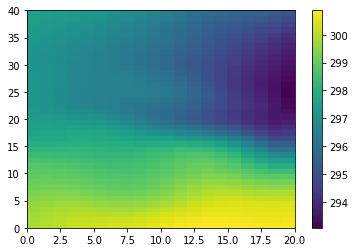

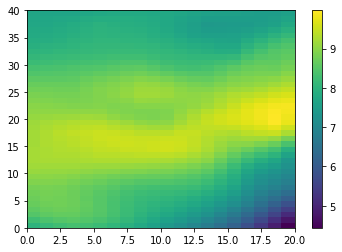

In [12]:
# Surface properties -- define ocean surface for simulations

s_names = ["Water skin temperature","Wind speed","Wind direction","Salinity"]
s_data = np.zeros([len(s_names), nala, nalo])  ## page/row/col
print('s_data shape: ',s_data.shape)

#tmean                   = 292.0 # sst mean
#wsp                     = 6.3   # 10m wind speed
# read era5 data directly from saved np arrays, already interpolated to ARTS grid defined
#s_data[0,:,:] = np.load('arrs/e5-ts_'+sgrid+'.npy') #### try using T2m instead of 
ss_in = np.load('arrs/e5-ss_'+sgrid+'.npy') ### ERA5 SST...
ss_in[ss_in<270] =  np.load('arrs/e5-ts_'+sgrid+'.npy')[ss_in<270] ### ERA5 T2m...
s_data[0,:,:] = ss_in # use ERA5 SST unless it's missing, then use T2m
s_data[1,:,:] = np.load('arrs/e5-wi_'+sgrid+'.npy')
s_data[2,:,:] = np.load('arrs/e5-wd_'+sgrid+'.npy')   # in deg from N, as expected by ARTS
s_data[3,:,:] = 0.034                       # token salinity value

# write these to ARTS variables 
ws.Copy(ws.surface_props_names, s_names)
ws.Copy(ws.surface_props_data, s_data)
ws.MatrixSetConstant(ws.z_surface, nala, nalo, 0.0) # explicitly set the surface to 0m altitude


# also profile information from ERA5:
ws.t_field.value[:,:,:] = np.load('arrs/e5-t_'+sgrid+'.npy')[::-1,:,:]
ws.vmr_field.value[0,:,:,:] = np.load('arrs/e5-mr_'+sgrid+'.npy')[::-1,:,:]*28.966/18.016 # convert MR to VMR
ws.p_grid.value[0] = np.mean(np.load('arrs/e5-sp_'+sgrid+'.npy')[:,:]) # just take mean from scene? not huge deal..

plt.pcolor(s_data[0,:,:]) # quick look for SST
plt.colorbar()
plt.show()
plt.pcolor(s_data[1,:,:]) # quick look for wsp
plt.colorbar()
plt.show()

# Define antenna pattern

In [13]:
# Set and calculate some basic variables for antenna and scanning

### All will be replaced or superseded if using L1R data as input
 
#zsat   = 699.7e3      # Satellite altitude [m] -- can read this in later
#vsat   = 6.76e3       # Satellite velocity [m/s]
#dt     = 2.6e-3       # Integration time [s] -- 2.6ms for low freqs, 1.3ms for 89GHz
#rpm    = 40           # Rotations per minute -- same for AMSR-E and AMSR2
# 
## nautical mile constant?  1852m = 1nmi
#m2deg  = 1/(60*1852)                          # Conversion from m to latitude
#dang   = dt * 360 * rpm / 60                  # Angular distance between samples
#dlat   = m2deg * vsat * 60 / rpm              # Latitude distance between scans
#print(dang,dlat)

In [14]:
# channel HPBW sizes in km, from amsr2 documentation
widths  = np.array([35., 35., 24., 14., 15.,  7., 3.])[fsub] # in km across
heights = np.array([62., 62., 42., 22., 26., 12., 5.])[fsub] #  per freq, 6/7/10/18/23/36/89

width  = 1.8           # Max half-width of antenna simulated (if HPBW is 1.8deg, width=2 covers 2x the HPBW)
resol  = 0.01          # angular resolution (same in zenith/azimuth)
# note: for a given angular resolution (might vary), width=2 yields 99.96% of total power @6GHz 
#   compared to width=20 and 99.99999% @10GHz, width=1.5 yields 99.0 and 99.994 @ 6,10
#resol, width = dang/(angfac*5), awidth # set here instead of calling func
print('angular resolution of response grid [deg]: ',resol)

adata = [[ 6.925e9 ,  1.80],   # AMSR2 center frequency and beamwidth (deg)
         [ 7.300e9 ,  1.80],   # assumed the same for V/H polarizations
         [ 10.65e9 ,  1.20],
         [ 18.70e9 ,  0.65],
         [ 23.80e9 ,  0.75],
         [ 36.50e9 ,  0.35],
         [ 89.00e9 ,  0.15]] 

adata = np.array(adata, order="C").transpose()[:,fsub] # choose selected frequencies (set above)

# define zenith, azimuth grid on the ground (relative to bore sight) -- assumed to be square, 2xWidth wide
x  = np.arange( -width, width+resol, resol )  #this gives angular antenna response points in za,aa
x2 = x**2   # since assumed origin is 0, do squaring here 
nf, nx = len(adata[0,:]), np.size(x)   # num frequencies, size of antenna grid

#print(ch_str)

from typhon.arts.griddedfield import GriddedField4
gf4 = GriddedField4()   # ARTS variable type, found in typhon
gf4.name = 'AMSR2 antenna response'
gf4.gridnames =  [ 'Polarisation', 'Frequency', 'Zenith angle', 'Azimuth angle' ]
###  note: za & aa are equally spaced, and we're treating V/H as having identical responses
if npol==2: gsp="1" 
else: gsp="0"
gf4.grids     = [ [gsp], adata[0,:], x, x ]
gf4.dataname  = 'Response'
gf4.data      = np.zeros([ 1, nf, nx, nx ], order="C")
print('size of antenna_reponse grid: ',gf4.data.shape)

for i in range(nf):
    si = adata[1,i] / (2*np.sqrt(2*np.log(2)))  # calculate standard deviation first, based on HPBW
    gf4.data[0,i,:,:] = np.exp( - np.tile(x2,[nx,1])/si**2 - np.tile(x2,[nx,1]).transpose()/ si**2 )


# frequency grid of simulation is defined according to sensor setup above (may change with use of metmm)
f_grid = np.copy(gf4.grids[1])  # array with each frequency (not channel)

ws.f_grid.value = f_grid
print('f_grid: ',ws.f_grid.value)
 
#plt.pcolormesh(gf4.data[0,0,:,:])# to plot antenna pattern of one freq
#plt.show()

angular resolution of response grid [deg]:  0.01
size of antenna_reponse grid:  (1, 6, 361, 361)
f_grid:  [6.925e+09 7.300e+09 1.065e+10 1.870e+10 3.650e+10 8.900e+10]


# Define bore sights for one scan, angular grid for fwd model

In [15]:
# now using real data, but while exact EIA is given in L1R the sensor zenith angle is 
#  assumed 47.0deg for all points. azimuth is also given but on earth (not sensor) so we calculate this
#  from spacecraft position

#  bore sights defined from middle scan, for all chosen pixels
#bsights = np.array([np.repeat(180-47.5,npix), eaz[pxt:pxp,scm]]).transpose() # size of [npix,2] 
# look at L1 documentation for how earth azimuth is defined (180 off the ARTS definition)
# assumes azimuth angle sequence will be same for each scan, and note that 89GHz B-scan is 180-47.0

# new calculation of boresights, using a derived azimuth angle (not L1R one)
# do this by defining sensor_pos for central scan, target as L1R la/lo on ground, and ARTS function to draw line
ws.sensor_pos = np.hstack([np.repeat(altitude,  npix+1).reshape(npix+1,1),
                           np.repeat(SClat[scm],npix+1).reshape(npix+1,1),
                           np.repeat(SClon[scm],npix+1).reshape(npix+1,1)])
targ_pos = np.hstack([ np.repeat(0,npix+1).reshape(npix+1,1),
                       ala[pxt:pxp+1,scm].reshape(npix+1,1),
                       alo[pxt:pxp+1,scm].reshape(npix+1,1)])
ws.sensor_losGeometricFromSensorPosToOtherPositions( target_pos=targ_pos )
print(ws.sensor_los.value)
print(ws.sensor_pos.value)
bs = np.copy(ws.sensor_los.value[:,:]) # all [npix+1,3] (one larger to compute angular grid easier below)
bsights = np.copy(ws.sensor_los.value[:npix,:]) # just [npix,3]

[[132.19882939 -53.22206376]
 [132.20136144 -53.84391155]
 [132.20390122 -54.46585138]
 [132.20645515 -55.08787902]
 [132.20900832 -55.70999514]
 [132.21157274 -56.33220753]
 [132.21414264 -56.95450146]
 [132.21671417 -57.57689352]
 [132.21929428 -58.19936686]
 [132.22187288 -58.82193166]
 [132.22445479 -59.44459023]
 [132.22704149 -60.06733883]
 [132.22962712 -60.69016045]
 [132.23221521 -61.313083  ]
 [132.23480273 -61.936102  ]
 [132.23738349 -62.55919223]
 [132.23996813 -63.18238249]
 [132.24255171 -63.80564716]]
[[ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05  1.73208425e+01 -1.19612919e+01]
 [ 6.99600000e+05 

In [16]:
# Define angular grid for pencilbeam calculations

# can use 'dang' or not, but benefit of using it is having RT calc at each boresight (i.e. antenna beam max)
#  in azimuth direction. if using 'dang' for zenith too then it's an evenly spaced angular grid.

n = np.floor( width * angfac )  # angular width * angular samples per deg (same width as antenna pattern grid)
#za_grid = np.array( 180-47.5 +  np.arange(-n,n+1)/angfac)  ## effectively taking 'width' on either side of 0
#
#mid_aa_grid = np.interp(np.arange(0,npix+1/angfac,1/angfac), np.arange(0,npix+1), eaz[pxt:pxp+1,scm] )
## need to add on az values on outside to get edges off boresight extremes
#aa_grid = np.concatenate(( 
#    (eaz[pxt,scm] - np.arange(np.diff(mid_aa_grid[0:2]),width,np.diff(mid_aa_grid[0:2])))[::-1],
#    mid_aa_grid,
#    (eaz[pxp,scm] + np.arange(np.diff(mid_aa_grid[-3:-1]),width,np.diff(mid_aa_grid[-3:-1]))) ))

#  NOTE: this working for Ascending AMSR2 orbit... might break for D or other sensor scan strategy...
za_grid = np.array( bsights[0,0] +  np.arange(-n,n+1)/angfac)  ## effectively taking 'width' on either side of 0
mid_aa_grid = np.interp(np.arange(0,npix+1/angfac,1/angfac), np.arange(0,npix+1), bs[:npix+1,1] )[:-1]
# need to add on az values on outside to get edges off boresight extremes
aa_grid = np.concatenate(( 
    (bs[0,1] + np.arange(abs(np.diff(mid_aa_grid[0:2])), width, abs(np.diff(mid_aa_grid[0:2])))[::-1]),
    mid_aa_grid,
    (bs[npix,1] - np.arange(abs(np.diff(mid_aa_grid[-3:-1])),width,abs(np.diff(mid_aa_grid[-3:-1])))) ))

#aa_grid[aa_grid>180] -=360 # limit to -180,180 domain (done internally in ARTS?)
#aa_grid[aa_grid<-180]+=360
print(za_grid.size, aa_grid.size)
print(np.mean(np.diff(aa_grid)),np.mean(np.diff(za_grid)))
#print('za grid: ',za_grid)
#print('az grid: ',aa_grid)
print(19*143,21*173,25*201)

21 137
-0.10376030891668965 0.1666666666666657
2717 3633 5025


In [17]:
# Set sensor_pos (position), sensor_los (line of sight) for ARTS

# sensor_pos should be columns of altitude, SClat, SClon  ###  
#   with real data these come from L1R files and transform X/Y/Z to lat/lon
#   currently one alt/sclat/sclon for each scan (i.e. each of nscans)

ws.sensor_pos = np.hstack([np.repeat(altitude, nscans).reshape(nscans,1),
                           SClat[sct:scp].reshape(nscans,1),
                           SClon[sct:scp].reshape(nscans,1)])
                          #np.array(lat0 - shift + dlat * ssteps).reshape(nscans,1), 
                          #np.repeat(lon0, nscans).reshape(nscans,1)])
print(np.shape(ws.sensor_pos))
targ_pos = np.hstack([ np.repeat(0,nscans).reshape(nscans,1),
                       ala[pxm,sct:scp].reshape(nscans,1),
                       alo[pxm,sct:scp].reshape(nscans,1)])
ws.sensor_losGeometricFromSensorPosToOtherPositions( target_pos=targ_pos )

#print(ws.sensor_los.value)


(11, 3)


In [18]:
# turn off jacobian calc for primary yCalc, keep clear-sky (non-scattering) setup
ws.jacobianOff()
ws.cloudboxOff()

# Set the surface agenda for ARTS

In [19]:
# define surface agenda (need transmittance to run FASTEM):
varnam = ["Optical depth"]
ws.Copy(ws.iy_aux_vars, varnam)
ws.VectorCreate( "transmittance" )
#ws.transmittance = np.ones( ws.f_grid.value.shape ) * 0.0  #  FOR TESTING ONLY!!!!!

@arts_agenda
def iy_surface_agendaPY(ws):
    ws.specular_losCalc()
    # if wanting to test transmittance values, comment out next 3 calls and set outside agenda...
    #  if ppathCalc is called and uses assumed inputs there are problems, so specify all!
    ws.ppathCalc(ws.ppath_agenda, ws.ppath_lmax, 
       ws.ppath_lraytrace, ws.atmgeom_checked, ws.t_field, ws.z_field, 
       ws.vmr_field, ws.f_grid, ws.cloudbox_on, ws.cloudbox_checked, 
       ws.ppath_inside_cloudbox_do, ws.rtp_pos, ws.specular_los, ws.rte_pos2 )
    ws.iyEmissionStandard()
    ws.transmittanceFromIy_aux(transmittance=ws.transmittance)
    ws.SurfaceFastem( transmittance = ws.transmittance, fastem_version=6 ) 
    ws.iySurfaceRtpropCalc()
    
ws.Copy(ws.iy_surface_agenda, iy_surface_agendaPY) # copy python-defined agenda to ARTS

# Perform checks and set up mblock grid

In [20]:
# perform some checks:
ws.abs_xsec_agenda_checkedCalc()
ws.propmat_clearsky_agenda_checkedCalc()
ws.atmfields_checkedCalc( bad_partition_functions_ok = 1 )
ws.atmgeom_checkedCalc()
ws.cloudbox_checkedCalc()

In [21]:
# create vector mblock_reference_los and matrix mblock_target_los (to be used by DiffZaAa)
#mblock_reference_los = np.array([180-47.5, eaz[pxm,scm]])   # choose angle from mid scan as reference point
ref_angs = bsights[int(npix/2),:]  # middle pix, middle scan
print('reference angles (for mblock, antenna):', ref_angs)
mblock_reference_los = ref_angs    # choose angle from mid scan as reference point

# want to have all individual angle pairs distinct... so repeat one serially and one n times
mblock_target_los = np.array(np.transpose( np.stack( 
                    [ np.repeat(za_grid, aa_grid.size) , 
                      np.tile(  aa_grid, za_grid.size) ]) ) , order = "C")
## need to specify 'C' order or else stride is wrong and array values are read wrong by ARTS!

# take the differences of zenith and azimuth angles to convert to chosen angle space
ws.DiffZaAa(ws.mblock_dlos_grid, mblock_reference_los, mblock_target_los)

#print(np.shape(ws.mblock_dlos_grid.value))
#print(np.diff(ws.mblock_dlos_grid.value[0:10,1]))

reference angles (for mblock, antenna): [132.21929428 -58.19936686]


In [22]:
### Calculate the sensor response function from the antenna response
ws.VectorCreate("antenna_reference_los")
ws.MatrixCreate("antenna_target_los")
#ws.antenna_reference_los = np.array([180-47.5, eaz[pxm,scm]])
ws.antenna_reference_los = ref_angs
ws.antenna_target_los = np.array(bsights, order="C")
ws.DiffZaAa(ws.antenna_dlos, ws.antenna_reference_los, ws.antenna_target_los)

# define sensor... done above, but apply gf4 typhon/arts object to antenna_response:
ws.sensor_norm = 1
ws.antenna_dim = 2
ws.antenna_response = gf4 

ws.sensor_responseInit()

## flipping from first two stokes components (I/Q) to V/H-pol Tb here... 
if npol == 2:
    ws.instrument_pol = [5,6] # indices for V,H (1,2 are I,Q)
if npol == 1:
    ws.instrument_pol = [1] # indices for V,H (1,2 are I,Q)

ws.sensor_responsePolarisation()
ws.sensor_responseAntenna()
ws.sensor_checkedCalc()



# Initiate the retrieval setup

In [23]:
# first, set up the retrieval grid, which is independent from fwd model and
#  independent from the background (lat/lon/alt) grid if chosen

r_lims = [lat0-uty, lat0+uty, lon0-utx, lon0+utx] # lat/lon limits  (box in middle of overall box)

r_lon  = np.arange(r_lims[2], r_lims[3]+r_reso, r_reso)
r_lat  = np.arange(r_lims[0], r_lims[1]+r_resa, r_resa)

print('retrieval grid resolution: ', r_resa, r_reso)
#print('retrieval lon grid: ', r_lon)
#print('retrieval lat grid: ', r_lat)

# create grids of retrieval lats/lons for calculations of distance and plotting below
ri, rj = np.meshgrid(r_lat, r_lon, indexing='ij')  
print(ri.shape,rj.shape)
# and the same for original ARTS background grid
gi, gj = np.meshgrid(ws.lat_grid, ws.lon_grid, indexing='ij')
print(gi.shape,gj.shape)

# calculate 'x_back' (or background), which is mapping s_data to the retrieval grid
x_back = np.zeros([nrvar, r_lat.size, r_lon.size])
print('rgrid dimensions: ',x_back.shape)
from scipy.interpolate import interp2d 
f = interp2d(ws.lon_grid, ws.lat_grid, s_data[0,:,:]) #, kind='cubic')
x_back[0,:,:] = f(r_lon,r_lat)
if nrvar>1:
    f = interp2d(ws.lon_grid, ws.lat_grid, s_data[1,:,:]) #, kind='cubic')
    x_back[1,:,:] = f(r_lon,r_lat)
#plt.matshow(x_back[0,:,:])
#plt.colorbar()
#plt.show()

retrieval grid resolution:  0.05 0.05
(56, 36) (56, 36)
(40, 20) (40, 20)
rgrid dimensions:  (2, 56, 36)


In [24]:
## map x_back to background grid in ARTS, check it looks right
#ws.x = np.concatenate([bla.flatten(order = "f") for bla in x_back])
#print(ws.x.value)
#ws.x2artsAtmAndSurf()
#plt.figure(figsize=[14,7])
#plt.pcolor(ws.surface_props_data.value[0,:,:])
#plt.colorbar()
#plt.show()

# Set prior and covariance matrices

Xa shape:  (2, 56, 36)
noise used in Se:  [0.68 0.68 0.86 0.86 1.4  1.4  1.4  1.4  1.4  1.4  2.4  2.4 ]
Se cov shape:  (2244, 2244)


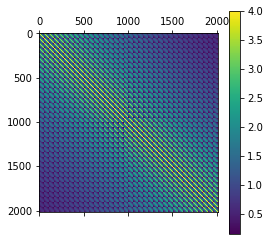

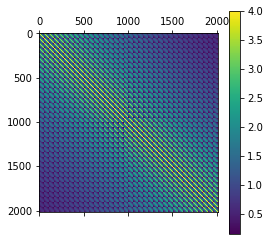

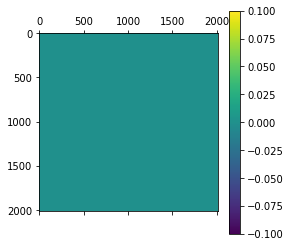

In [25]:

# set Xa (formally set in ARTS below)
xa = np.zeros([nrvar, r_lat.size, r_lon.size]) # a priori matrix
xflat = np.zeros([nrvar, r_lat.size, r_lon.size]) # 'flat' x for first guess, just means of xa fields
print('Xa shape: ', xa.shape)
xa[0,:,:] = x_back[0,:,:] #+np.random.normal(0,1,[r_lat.size,r_lon.size]) #+ 0.07  # set constant, or maybe some perturbation
if nrvar>1:
    xa[1,:,:] = x_back[1,:,:]
for n in range(nrvar):
    xflat[n,:,:] = np.mean(xa[n,:,:]) #, axis=(1,2))

# then observation errors (first just sensor noise)
all_noise = np.repeat((noise_fac*nedt),2)
if scene == 'aus': all_noise[1],all_noise[3],all_noise[5] = 50,50,2 # no weighting to 6H/7H in this case, less for 10H
print('noise used in Se: ',all_noise)
se_cov = np.diag(np.tile( all_noise**2, npix*nscans )) 
#se_cov = np.diag(np.tile(np.repeat((noise_fac*nedt)**2,2), npix*nscans )) 
print('Se cov shape: ', se_cov.shape) # square matrix of side length npix*nscans*nf*2

# calculate distances between points on retrieval grid for distance-dependent correlations in sx_cov
#   "Convert a vector-form distance vector to a square-form distance matrix"
#dists = squareform( pdist( np.array([ri.flatten(), rj.flatten()]).transpose() )) 
dists = squareform( pdist( np.array([ri.flatten(order="F"), rj.flatten(order="F")]).transpose() )) 
# ri/rj flattened in F order because all 2D arrays interpreted in 1D by arts get reshaped internally!

# can try making decorrelation lengths gradient-dependent (wait for a non-flat prior for testing!):
#rygrad, rxgrad = np.gradient(xa[:,:,0])
#pseudo_grad = 0.5 * (np.abs(rygrad)*r_resa + np.abs(rxgrad)*r_reso)   # should be array of xa size
## abs values, add gradients in x and y by retr grid resolution
#deco_grid = np.ones_like(dists)*deco
#deco_grid[pseudo_grad > 0] *= np.exp(-1.0*pseudo_grad[pseudo_grad>0])  
## ad hoc, weight decorr length to be shorter if there's a non-zero gradient in apriori 


# then a priori state errors (Sa or Sx)
len_rgrid = r_lat.size*r_lon.size # total number of points in retrieval grid
nsx = np.sum(range(nrvar+1)) # 'triangle number' determines # of matrix blocks that define sx_cov

# blocks of larger, sparse Sa unless the off-off diagonal elements are filled in (SST/wsp covariances)
sx_cov = np.zeros([len_rgrid,len_rgrid, nsx], order="C")

# common for both:
sx_cov[:,:,0] = np.diag( np.tile(sx_sst**2, len_rgrid)) 
corrs_sst = np.exp(-dists/deco_sst) 
if deco_sst > .1:
    sx_cov[:,:,0]  = sx_sst * sx_sst * corrs_sst[:,:]  # FOR NON-LOC-DEP SX_SST    i.e.  cov = r * sig * sig
#for x in range(len_rgrid):
#    for y in range(len_rgrid):
#        sx_cov[x,y,0]  = sx_sst * sx_sst * corrs_sst[x,y]  # i.e.  cov = r * sig * sig
    
if nrvar==2:  # wind and cross-correlations
    corrs_wsp = np.exp(-dists/deco_wsp)
    sx_cov[:,:,1] = np.diag( np.tile(sx_wsp**2, len_rgrid)) 
    if deco_wsp > .1:
        sx_cov[:,:,1] = sx_wsp * sx_wsp * corrs_wsp[:,:]  # if sx_wsp is NOT function of loc, calc here
    #sx_cov[:,:,2] = sx_wsp * sx_sst * corrs_wsp[:,:] * xcorr  # cross correlations -- again, NOT f(loc)
    #for x in range(len_rgrid):
    #    for y in range(len_rgrid):
    #        sx_cov[x,y,1]  = sx_wsp * sx_wsp * corrs_wsp[x,y]  # if sx_wsp is function of loc, include here
    #        # cross correlations! (w/ spatial corr from 1):
    #        sx_cov[x,y,2]  = sx_wsp * sx_sst * corrs_wsp[x,y] * xcorr  # cross correlations

for rv in range(nsx):   # can plot each a priori covariance matrix block:
    plt.matshow(sx_cov[:,:,rv])
    plt.colorbar()
    plt.show()


# Finalize retrieval setup in ARTS, run yCalc for syn. observation vector

In [26]:

tb_obs = tb_cal[pxt:pxp, sct:scp, :]  # input observed TBs with calibration offsets applied
tb_obs_reshape = np.transpose(tb_obs,axes=(2,1,0)) # so to [chans,scans,pix] # from [px,sc,ch] -> [ch,sc,px]
print(tb_obs_reshape.shape)
tbo_flat = np.zeros([nscans*npix*nch])

for c in range(nf*2):
    tbo_flat[c::nf*2] = tb_obs_reshape[c,:,:].flatten() #order="F")
    
#tb_back = np.zeros([nscans,npix,nf*2]) 
#for c in range(nf*2):
#    tb_back[:,:,c] = tbo_flat[c::nf*2].reshape(nscans,npix)

# define first guess for x in iteration. if no ws.x is set before OEM runs, it uses ws.xa.
#### flatten xa/whatever in correct order for ARTS
#firstg = np.concatenate([bla.flatten(order = "f") for bla in xa])
firstg = np.concatenate([bla.flatten(order = "f") for bla in xflat])
ws.x = firstg
#ws.x = ws.xa #firstg

(12, 11, 17)


In [27]:
# formally set covarainces and prior for ARTS OEM:
#  [use numpy copy to make damn sure arrays are separate in memory]

ws.retrievalDefInit()  # initialize then add variables

for r in range(nrvar):
    ws.retrievalAddSurfaceQuantity( g1=r_lat, g2=r_lon, quantity=s_names[r])
    ws.covmat_sxAddBlock(block = np.copy(np.squeeze(sx_cov[:,:,r])), i=r, j=r )  # for 'diagonal' blocks
    
# for cross-correlation blocks (if more than 2 vars, revisit this):
#if nrvar>1:
#    ws.covmat_sxAddBlock(block = np.copy(np.squeeze(sx_cov[:,:,2])), i=0, j=r )

xa_forarts = np.concatenate([bla.flatten(order="F") for bla in xa])  # ordering bullshit
#xa_forarts = xa.flatten()
ws.Copy(ws.xa, np.copy(xa_forarts))  # copy python xa to arts xa (everything collapsed to 1D)

ws.covmat_seSet(np.copy(se_cov))

ws.retrievalDefClose()


In [28]:
#jqs = ws.jacobian_quantities.value
#rq =  jqs[0]
#rq.grids

# Define the iteration agenda for ARTS

In [29]:
# include 'clip' limits for retrieved variables
from IPython.display import display, clear_output
ic = 0
#draw_fun = fig.canvas.draw
plt.ion()
#f, axs = plt.subplots(1, 2)
#ax_sst, ax_w = axs
#f.show()
#
#def update():
#    f.canvas.draw()
ceems = cmo.solar
ceemb = cmo.balance

@arts_agenda
def inversion_iterate_agenda(ws):
    ws.Ignore(ws.inversion_iteration_counter) # on simon's advice
    
    ws.xClip(ijq = 0, limit_low = 272.0, limit_high = 310.0)  #limits retrieval range of SST
    if nrvar>1: ws.xClip(ijq = 1, limit_low = 0.5, limit_high = 20.0)  # limits wind_speed range
        
    ws.x2artsAtmAndSurf()  # map x to ARTS's variables -- THIS INVOLVES ARTS RESHAPE OF 1D to 3D FIELDS!
    
    x_iter = np.copy( ws.x.value ).reshape(nrvar, r_lat.size, r_lon.size) 
    xb_iter = np.copy( ws.surface_props_data.value ).reshape(4, nala, nalo) # on arts background grid
    
    ws.yCalc() 

    ws.Copy(ws.y_baseline, np.zeros([tbo_flat.size])) # kinda silly but necessary?
    ws.VectorAddVector( ws.yf, ws.y, ws.y_baseline )  # add baseline term (need to create ws.yf)
    
    # this takes care of some fixes needed to get the jacobian right for iterative solutions:
    ws.jacobianAdjustAndTransform()
    
    #
    # Debug stuff: view fields as iteration progresses (will show up below OEM call)
    
    if np.mod(ic,2)==0:
        f, (ax_sst, ax_w) = plt.subplots(1, 2, figsize=[18,7])
    
        ax_sst.set_title('SST, Iter='+str(ic//2))
        ax_w.set_title('Wind, Iter='+str(ic//2))
    
        vch = 3 # cbar change value (both sst/wsp)
        ax_sst.matshow(xb_iter[0,:,:]-s_data[0,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
        sms = plt.cm.ScalarMappable(cmap=ceemb, norm= plt.Normalize(vmin=-vch,vmax=vch))
        sms._A = []
        cbs = plt.colorbar(sms, ax=ax_sst)
        if nrvar>1:
            ax_w.matshow(xb_iter[1,:,:]-s_data[1,:,:], vmin=-vch, vmax=vch, cmap=ceemb)
            smw = plt.cm.ScalarMappable(cmap=ceemb, norm= plt.Normalize(vmin=-vch,vmax=vch))
            smw._A = []
            cbw = plt.colorbar(smw, ax=ax_w)
    
        clear_output(wait=True)
        display(f)  # outputs figure with x vectors to screen
        #display('grid vars updating (unreshaped): ',ws.x.value) #x_iter[1,:,:])
    
    ic += 1

ws.Copy(ws.inversion_iterate_agenda, inversion_iterate_agenda)

# Call OEM

In [30]:
# y_geo doesn't get initialized/set if a yCalc isn't called outside of ARTS OEM???
print('start of yCalc')
ws.yCalc() 
print('finished initial yCalc')


start of yCalc
finished initial yCalc


In [31]:
# initialize y vector

# disregard initial yCalc
ws.Copy(ws.y, tbo_flat )  # copy to the ARTS y vector prior to running OEM.
#ws.Copy(ws.y, tb_obs_reshape )  # copy to the ARTS y vector prior to running OEM

if np.diagonal(se_cov).size != tb_obs.size:
    print('Se covariance matrix and Tb vector not same size!')
    aaaaandstop

print('last gasp')

last gasp


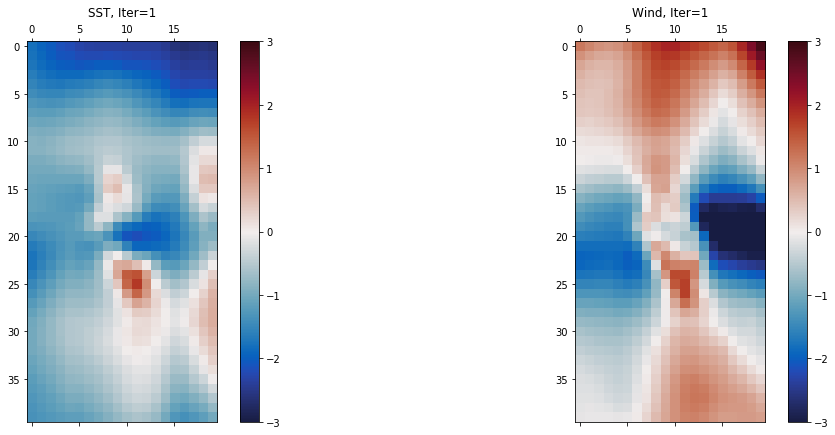

ARTS[94371963208352]:     2       0.320229      0.0245201       0.295709       0.036841
ARTS[94371963208352]: --------------------------------------------------------------------------------
ARTS[94371963208352]: 
ARTS[94371963208352]: Total number of steps:            2
ARTS[94371963208352]: Final scaled cost function value: 0.320229
ARTS[94371963208352]: OEM computation converged.
ARTS[94371963208352]: 
ARTS[94371963208352]: Elapsed Time for Retrieval:                       78.8475
ARTS[94371963208352]: Time in inversion_iterate Agenda (No Jacobian):   42.6791
ARTS[94371963208352]: Time in inversion_iterate Agenda (With Jacobian): 34.0705
ARTS[94371963208352]: 
ARTS[94371963208352]:                                       ----                                      
ARTS[94371963208352]: 

Completion time [s]: 175.79054880142212


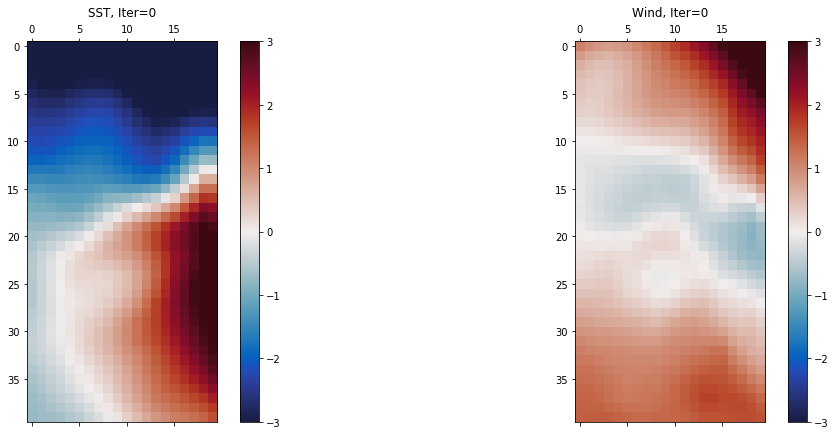

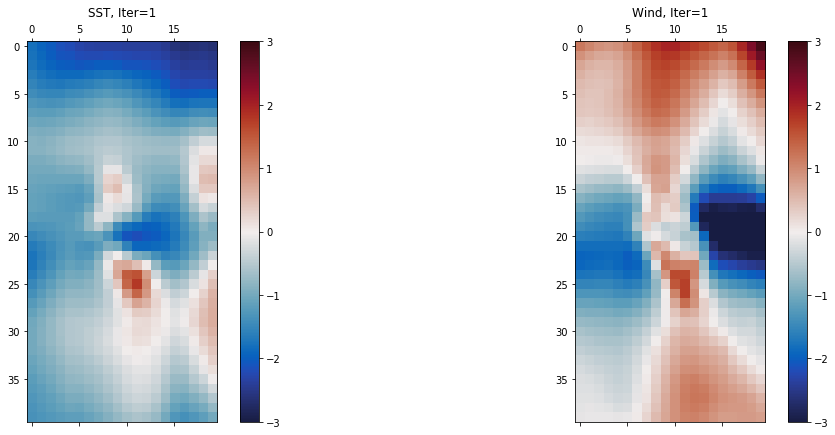

In [32]:
# Call OEM:

#  note: LM is better for non-linear problems and sfc retrieval should be very linear, so stick with GN/GN_CG
ws.OEM(method="gn",  # in one test LM took ~3x longer than GN!!
    max_iter=5,
    display_progress=1,
    max_start_cost=1e5,
    stop_dx=.4, # default is .01? -- this is to limit iterations, can dial back later for more exactness
    lm_ga_settings=np.array([10.0,2.0,3.0,10000000000.0,1.0,1.0])) # only applicable if method='lm'

ws.Print(ws.oem_errors, 0)  # print any errors to terminal

endt = time. time()
print('Completion time [s]:',endt - startt)

In [33]:
###### calculate averaging kernel (A matrix) and a posteriori 
# A matrix, S_o, S_s are all same size: [x,x] where x=npix*nscans*nretvar
ws.avkCalc()
Amat = ws.avk.value
print('Trace of A Matrix: ', np.trace(Amat))   #Trace(A) yields DOF for signal.
print('(out of possible points and vars:',np.diagonal(Amat).size)
print('  ...so DOF per retr grid point: ',np.trace(Amat)/np.diagonal(Amat).size)

ws.covmat_soCalc()
post = ws.covmat_so.value  # posterior error covariance matrix
ws.covmat_ssCalc()
smoov = ws.covmat_ss.value  # posterior error covariance matrix
# should be [x,x], providing uncertainties of each retrieved var, where x=npix*nscans*nretvar
 
### ARTS method: "Extracts error estimates for retr quantities from covariance
##  matrices for the error due to measurement noise covmat_so and the error 
##  due to limited resolution of the observation system" -- fwd model and smoothing errors.
ws.retrievalErrorsExtract( ws.covmat_so, ws.covmat_ss)  
#ws.retrievalErrorsExtract( ws.retrieval_eo, ws.retrieval_ss, ws.covmat_so, ws.covmat_ss) # returns first two 
print(np.shape(ws.retrieval_eo.value), np.shape(ws.retrieval_ss.value))
obs_err = np.copy(ws.retrieval_eo.value[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
smo_err = np.copy(ws.retrieval_ss.value[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))

# [fixed via correct angular grid representation?]
# some smoothing errors can show up as negative values in covmat_ss diagonal...
#smo_err[smo_err != smo_err] = 0.0
if nrvar>1:
    obs_err2 = np.copy(ws.retrieval_eo.value[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))
    smo_err2 = np.copy(ws.retrieval_ss.value[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))
    #smo_err2[smo_err2 != smo_err2] = 0.0
    
# diagnostics: 0: convergence=0  
#              1: Start value of cost function.
            #  2: End value of cost function.
            #  3: End value of y-part of cost function.
            #  4: Number of iterations used.
gnostic = np.copy(ws.oem_diagnostics.value)
x_cost = gnostic[2]-gnostic[3]
y_cost = gnostic[3]
print('X-cost, Y-cost: ', x_cost, y_cost)
#gain = np.copy(ws.dxdy.value)  # can look at this later?
#print(gain.shape)
    

Trace of A Matrix:  76.55380991178768
(out of possible points and vars: 4032
  ...so DOF per retr grid point:  0.018986559997963216
(4032,) (4032,)
X-cost, Y-cost:  0.0245200939926839 0.2957091501485968


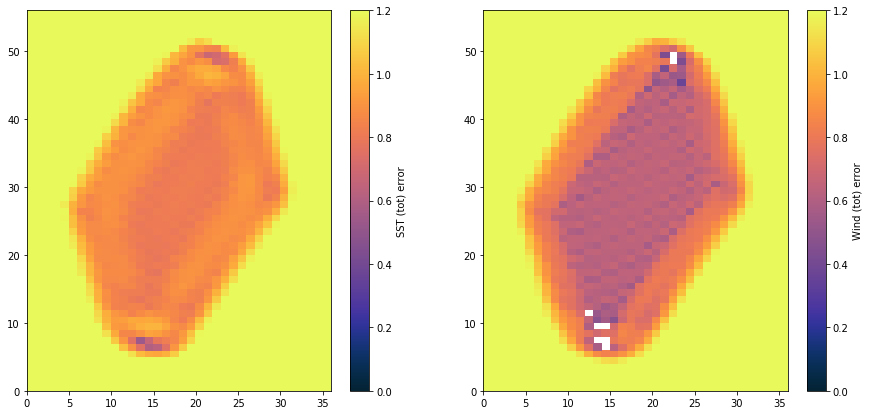

In [34]:
# save total errr plot
f, axs = plt.subplots(1, 2, figsize=[15,7])
ax_sst, ax_wsp = axs
errno = plt.Normalize(vmin=.0,vmax=1.2)
cm=cmo.thermal
ax_sst.pcolor(obs_err +smo_err,  norm=errno, cmap=cm)
ax_wsp.pcolor(obs_err2+smo_err2, norm=errno, cmap=cm)
sm = plt.cm.ScalarMappable(cmap=cm, norm=errno)
sm._A = []
cb = plt.colorbar(sm,ax=ax_sst,label='SST (tot) error')
sm2 = plt.cm.ScalarMappable(cmap=cm, norm=errno)
sm2._A = []
cb2 = plt.colorbar(sm2,ax=ax_wsp,label='Wind (tot) error')
if sv: plt.savefig('imgr/tot-err_'+pv+'.png',bbox_inches='tight',dpi=350)
plt.show()

['2.38E-1', '4.45E-1', '3.50E-1', '5.54E-2'] ['2.28E-1', '4.52E-1', '3.45E-1', '6.65E-2']
['1.59E-1', '1.81E+0', '1.01E+0', '4.16E-1'] ['8.64E-2', '1.80E+0', '9.24E-1', '4.57E-1']


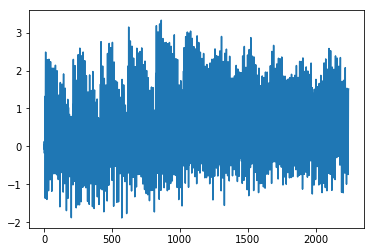

In [35]:
# from middle of retrieval grid, judge where the dominant error is coming from:
#    [need to choose more general indices here]
#print('ratio of smoothing to obs error (sst): ',np.nanmean(smo_err[5:-5,8:-8]/obs_err[5:-5,8:-8]))
#print('ratio of smoothing to obs error (wsp): ',np.nanmean(smo_err2[5:-5,8:-8]/obs_err2[5:-5,8:-8]))
print(info(obs_err),info(obs_err2))
print(info(smo_err),info(smo_err2))
#andstophere

#print( smo_err[5:-5,8:-8])
#lt.pcolor(obs_err2+smo_err2,vmin=vmi,vmax=vma)
#lt.colorbar()
#lt.show()
plt.plot(ws.y.value - ws.yf.value)  # quick dump of sim vs. 'obs' TBs in no (meaningful) order

# Map variables back to scan/pixel arrays

In [36]:
# yf is y_fit whereas y itself is the measurement vector here, so obs-sim is y-yf:
ydif = np.copy( ws.y.value - ws.yf.value )
ysim = np.copy( ws.yf.value)

xretr = np.zeros_like(x_back)
xretr[0,:,:] = np.copy(ws.x.value[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
if nrvar>1:
    xretr[1,:,:] = np.copy(ws.x.value[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))

xdif = xretr - x_back    # save retr vs prior/background on rgrid
xdif_a = xretr - xa       # save difference of apriori vs retrieved

geo = np.copy(ws.y_geo.value) #columns are altitude, lat, lon, zenith, azimuth of measurement geoposition
print(np.shape(ws.y.value))
# y vector should be of size [nf*2 (stokes dim 2) ] * npix*nscans  

# vars coming out of yCalc should be in order, nch then npix then nscans, i.e.:
## with nch=6 first 6 values are from pix1,sc1 then next 6 are pix2,sc1 and so on -- be careful!
# can compare geo[:,3] (az) to EIA from L1R (later), just 180-az to get EIA


# convert vectors back to scan/pixel matrices:
sim_tb = np.zeros([nscans,npix,nf*2])
dif_tb = np.zeros([nscans,npix,nf*2]) 
arts_pos = np.zeros([nscans,npix,4]) 
print(nf*2,npix,nscans)

for c in range(nf*2):
    sim_tb[:,:,c] = ysim[c::nf*2].reshape(nscans,npix)
    dif_tb[:,:,c] = ydif[c::nf*2].reshape(nscans,npix)
    for bb in range(4):
        arts_pos[:,:,bb] = geo[c::nf*2,bb+1].reshape(nscans,npix)  # lat,lon,zenith,azimuth
        ## arts obs points -- can differ slightly from prescribed, defined where max response is registered!

(2244,)
12 17 11


(2016, 56, 36)
1036 28
A1 sum:  0.9958673343114883
A2 sum:  1.0000114337281383


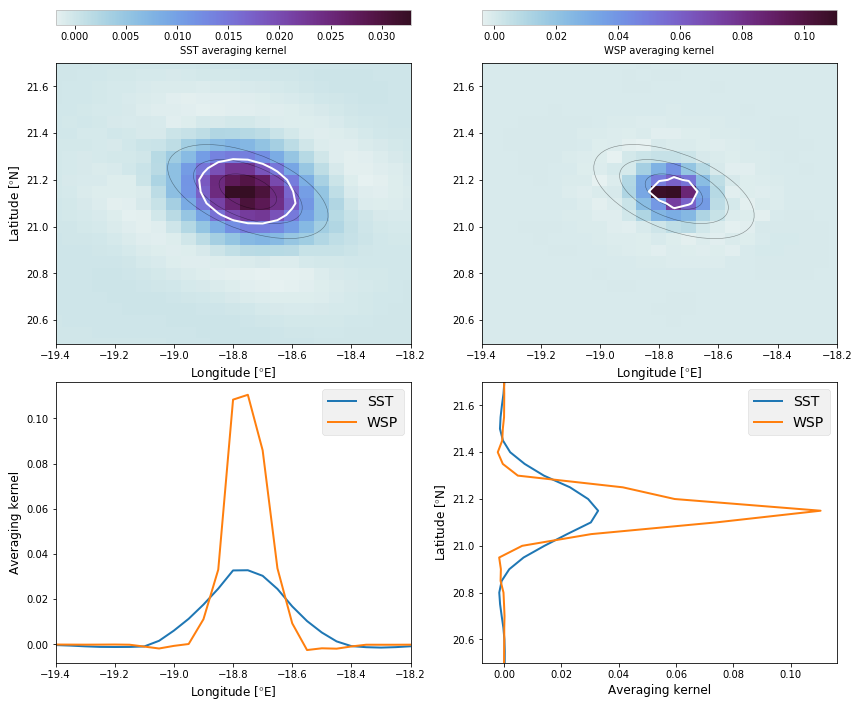

In [37]:
#Amat_d_re = np.zeros_like(x_back) # just diagonal elements from A matrix, back to rlat/rlon grid
#Amat_d_re[0,:,:] = np.copy( np.diagonal(Amat)[:len_rgrid].reshape(r_lat.size,r_lon.size,order="F"))
#if nrvar>1:
#    Amat_d_re[1,:,:] = np.copy( np.diagonal(Amat)[len_rgrid:].reshape(r_lat.size,r_lon.size,order="F"))
    
# want to fill [npts,rlat,rlon] grid with A values for each retrieval var

Amat_chosen1 = np.copy( Amat[:len_rgrid, :len_rgrid].reshape(len_rgrid,r_lat.size,r_lon.size,order="F") )
print(np.shape(Amat_chosen1))
# first quadrant of Amat (SST)
if nrvar>1:
    ## 2nd quadrant of Amat (wind)
    Amat_chosen2 = np.copy( Amat[len_rgrid:, len_rgrid:].reshape(len_rgrid,r_lat.size,r_lon.size,order="F") )

# pick a rgrid point in middle of grid and extract Amat:
 # [if even number of points in rlon grid, need this to pick point near center of grid]
rchos= int(r_lat.size/2)
ehn = int(len_rgrid/2.0 +rchos)
print(ehn, rchos)
print('A1 sum: ',np.sum(Amat_chosen1[ehn,:,:]))
print('A2 sum: ',np.sum(Amat_chosen2[ehn,:,:]))

# try gridspec?
import matplotlib.gridspec as gridspec
f1 = plt.figure(figsize=[14,12])
gs = gridspec.GridSpec(3, 2, height_ratios = [0.05, 1.0, 1.0])#, figsize=[14,14])
ax_cb1 = plt.subplot(gs[0, 0])
ax_cb2 = plt.subplot(gs[0, 1])
# Plot first image and draw colorbar in axes above.
ax_im1 = plt.subplot(gs[1, 0])
ax_im2 = plt.subplot(gs[1, 1])
ax_p1  = plt.subplot(gs[2, 0])
ax_p2  = plt.subplot(gs[2, 1])
#img = ax_img1.pcolormesh(...)
#plt.colorbar(img, cax = ax_cb1, orientation = "horizontal")

plt.style.use('bmh')
#f,ax = plt.subplots(1,2, figsize=[14,5], sharex=True, sharey=True)
#f, ax = plt.subplots(2,2, figsize=[14,12])#, sharey='row')
fs = 14
# to fix the lat/lon, since pcolor uses grid corners not midpoints:
rjp = rj-r_reso/2
rip = ri-r_resa/2
pangl = -np.mean(arts_pos[:,:,3])  # just taking the mean angular orientation of FOVs from whole scene
awidths = widths * 360.0/40075. #/ np.abs(np.cos(np.mean(ri)*np.pi/180.)) # scale widths by cos(lat)
aheights= heights* 360.0/40075. 
if scene=='canary': aheights /= np.abs(np.cos(np.mean(ri)*np.pi/180.)) # scale widths by cos(lat)
if scene=='aus': awidths /= np.abs(np.cos(np.mean(ri)*np.pi/180.)) # scale widths by cos(lat)
achans = [0,4,6]#,8]

cmavk = cmo.dense
av1mx = np.max(Amat_chosen1[ehn,:,:])
avoff = 0.6  # degrees width on either side to be shown in figures
thenorma1 = plt.Normalize(vmin=np.min(Amat_chosen1[ehn,:,:]),vmax=av1mx)
im1 = ax_im1.pcolormesh(rjp,rip,Amat_chosen1[ehn,:,:], cmap=cmavk, norm=thenorma1)
#ax_im1.set_aspect(1)
ax_im1.contour(rj,ri, Amat_chosen1[ehn,:,:], levels=[av1mx/2,av1mx], colors='white')
cb1 = plt.colorbar(im1, cax=ax_cb1, label='SST averaging kernel', orientation='horizontal')
#sm1 = plt.cm.ScalarMappable(cmap=cmavk, norm=thenorma1)
#sm1._A = []
#cb1 = plt.colorbar(sm1, ax=ax[0,0], label='SST averaging kernel', orientation='vertical')
max_ind = np.unravel_index(np.argmax(Amat_chosen1[ehn,:,:], axis=None), rj.shape)
ella = [Ellipse(xy=[rj[max_ind],ri[max_ind]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=pangl, linewidth=0.6, alpha=0.4, fill=False, color='black') for k in achans]
ax_im1.set_xlim([lon0-avoff, lon0+avoff]) #(if) shared axes, applies to both
ax_im1.set_ylim([lat0-avoff, lat0+avoff]) 
ax_im1.set_ylabel('Latitude [$\degree$N]', fontsize=fs-2)
ax_im1.set_xlabel('Longitude [$\degree$E]', fontsize=fs-2)
ax_im2.set_xlabel('Longitude [$\degree$E]', fontsize=fs-2)
for el in ella:
    ax_im1.add_artist(el)
if nrvar>1:
    av2mx = np.max(Amat_chosen2[ehn,:,:])
    thenorma2 = plt.Normalize(vmin=np.min(Amat_chosen2[ehn,:,:]),vmax=av2mx)
    #sm2 = plt.cm.ScalarMappable(cmap=cmavk, norm=thenorma2)
    #sm2._A = []
    #cb2 = plt.colorbar(sm2, ax=ax[0,1], label='WSP averaging kernel', orientation='vertical')
    max_ind = np.unravel_index(np.argmax(Amat_chosen2[ehn,:,:], axis=None), rj.shape)
    ella2 = [Ellipse(xy=[rj[max_ind],ri[max_ind]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=pangl, linewidth=0.6, alpha=0.4, fill=False, color='black') for k in achans]
    im2 = ax_im2.pcolormesh(rjp,rip,Amat_chosen2[ehn,:,:], cmap=cmavk, norm=thenorma2)
    #ax_im2.set_aspect(1)
    ax_im2.contour(rj,ri, Amat_chosen2[ehn,:,:], levels=[av2mx/2,av2mx], colors='white')
    cb2 = plt.colorbar(im2, cax=ax_cb2, label='WSP averaging kernel', orientation='horizontal')
    for el in ella2:
        ax_im2.add_artist(el)
    ax_im2.set_xlim([lon0-avoff, lon0+avoff]) #(if) shared axes, applies to both
    ax_im2.set_ylim([lat0-avoff, lat0+avoff]) 
        
ax_p1.plot(rj[int(r_lat.size/2),:], Amat_chosen1[ehn,int(r_lat.size/2),:], label='SST')
ax_p1.plot(rj[int(r_lat.size/2),:], Amat_chosen2[ehn,int(r_lat.size/2),:], label='WSP')
ax_p1.set_ylabel('Averaging kernel', fontsize=fs-2)
ax_p1.set_xlabel('Longitude [$\degree$E]', fontsize=fs-2)
ax_p1.set_xlim(lon0-avoff, lon0+avoff)
ax_p1.legend(fontsize=fs)
ax_p2.plot(Amat_chosen1[ehn,:,int(r_lon.size/2)],ri[:,int(r_lon.size/2)],  label='SST') #10:38
ax_p2.plot(Amat_chosen2[ehn,:,int(r_lon.size/2)],ri[:,int(r_lon.size/2)],  label='WSP')
ax_p2.set_ylim(lat0-avoff, lat0+avoff)
ax_p2.set_ylabel('Latitude [$\degree$N]', fontsize=fs-2)
ax_p2.set_xlabel('Averaging kernel', fontsize=fs-2)
ax_p2.legend(fontsize=fs)
        
apvr = 'v2'
#f.savefig('imgr/avgk_2pan_overlaid_'+pv+'_'+apvr+'.png', bbox_inches='tight', dpi=300)
plt.savefig('imgr/avgk_4pan_overlaid_'+pv+'_'+apvr+'.png', bbox_inches='tight', dpi=300)


In [38]:

# take one row of A matrix from each retr variable block:
#dexes = np.random.choice(range(len_rgrid), 10)
#for c in dexes:
#    print('sst @',c,np.sum(Amat[:len_rgrid, :len_rgrid][c,:]))
#    print('wsp @',c,np.sum(Amat[len_rgrid:, len_rgrid:][c,:]))

In [39]:
# looks like (with all freqs) wind has maybe 12-20km resolution,  more like 20-30km for SST
#f, axs = plt.subplots(1, 2, figsize=[15,6])
#axs[0].plot(rj[int(r_lat.size/2),:], Amat_chosen1[ehn,int(r_lat.size/2),:], label='SST')
#axs[0].set_ylabel('Averaging kernel', fontsize=fs-2)
#axs[0].set_xlabel('Longitude [$\degree$E]', fontsize=fs-2)
#axs[0].plot(rj[int(r_lat.size/2),:], Amat_chosen2[ehn,int(r_lat.size/2),:], label='WSP')
#axs[0].set_xlim(lon0-avoff, lon0+avoff)
#axs[0].legend(fontsize=fs)
#axs[1].plot(ri[:,int(r_lon.size/2)], Amat_chosen1[ehn,:,int(r_lon.size/2)], label='SST') #10:38
#axs[1].plot(ri[:,int(r_lon.size/2)], Amat_chosen2[ehn,:,int(r_lon.size/2)], label='WSP')
#axs[1].set_xlim(lat0-avoff, lat0+avoff)
#axs[1].set_xlabel('Latitude [$\degree$N]', fontsize=fs-2)
#axs[1].legend(fontsize=fs)
#if sv: plt.savefig('imgr/avg-kernel_'+pv+'.png', bbox_inches='tight', dpi=200)

In [40]:
# plot out dif_tb:
#for c in range(nch): #[0,1,2,3,4,5,6,7,8,9]:
#    plt.plot(dif_tb[:,:,c])

['-1.24E-2', '3.19E-5', '-6.03E-3', '3.78E-3']
['-1.47E-4', '5.45E-3', '2.95E-3', '1.65E-3']


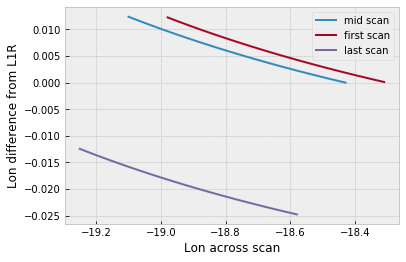

In [41]:
# as a check on the angular setup, make sure that y_geo from ARTS (position of each boresight)
#  matches (almost exactly) the L1R lat/lon values:
print(info(arts_pos[:,:,1]-alo[pxt:pxp,sct:scp].transpose()))
print(info(arts_pos[:,:,0]-ala[pxt:pxp,sct:scp].transpose())) # stats on location differences

#  shows difference in L1 vs. ARTS longitude from middle, first, and last scans run:
plt.plot( alo[pxt:pxp,scm], alo[pxt:pxp,scm]-arts_pos[int(nscans/2),:,1],label='mid scan')
plt.xlabel('Lon across scan')
plt.ylabel('Lon difference from L1R')
plt.plot( alo[pxt:pxp,sct], alo[pxt:pxp,sct]-arts_pos[0,:,1],label='first scan')
plt.plot( alo[pxt:pxp,scp], alo[pxt:pxp,scp]-arts_pos[-1,:,1],label='last scan')
plt.legend()
plt.show()

# Plot results

In [49]:
# plotting representative ellipses:
# first define widths/heights of ellipses that represent HPBW FOV for each freq:
#widths  = np.array([35., 35., 24., 14., 15.,  7., 3.])[fsub] # in km across
#heights = np.array([62., 62., 42., 22., 26., 12., 5.])[fsub] #  per freq, 6/7/10/18/23/36/89
#if los0[0] != 132.5:
#    print('ELLIPSE SIZES INCORRECT DUE TO non-AMSR sensor angle')

# convert (roughly!) to deg near equator... okay as first approximation for plotting...
#  if plotting near poles then will need to be more rigorous.
#widths *= 360.0/40075. / np.abs(np.cos(np.mean(ri)*np.pi/180.)) # scale widths by cos(lat)
#print(widths)
#heights*= 360.0/40075. # deg/circumference
#print(heights)

#print('VERIFY THAT THESE ARE WHOLLY EVEN ON THE GRID!')
#print(np.diff(arts_pos[0,:,1]))
#print(np.diff(arts_pos[:,0,0]))

projj = ccrs.PlateCarree()
inn =  0.5
rinn= 0.0 
if scene=='canary': rinn = 0.1
reg = [np.min(la_grid)+inn, np.max(la_grid)-inn,
           np.min(lo_grid)+inn, np.max(lo_grid)-inn]
rreg = [np.min(r_lat)+rinn, np.max(r_lat)-rinn,
           np.min(r_lon)+rinn, np.max(r_lon)-rinn]
print('region: ',reg)
print('r region: ',rreg)
rreg = np.round(rreg,1)
print('r region: ',rreg)

region:  [18.6, 23.6, -19.8, -17.8]
r region:  [19.85, 22.400000000000038, -19.55, -17.99999999999998]
r region:  [ 19.8  22.4 -19.6 -18. ]


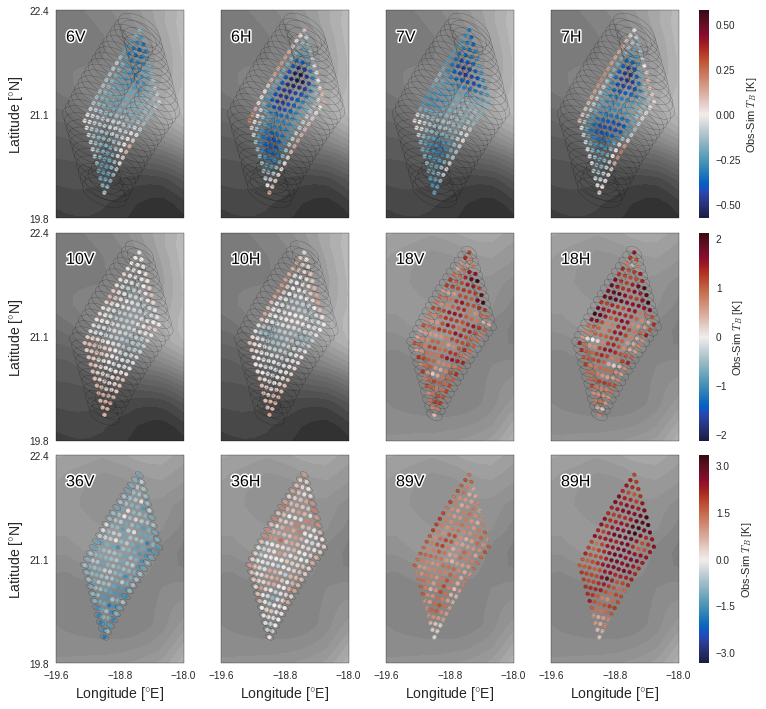

In [50]:
plt.style.use('seaborn')

ydif_figsize = [12,12]
if scene=='aus': ydif_figsize = [16,8]
f2 = plt.figure(figsize=ydif_figsize)

#f, ax_tb = plt.subplots(nrows=int(np.ceil(nf/2)), ncols=4, figsize=ydif_figsize,
#                        subplot_kw=dict(projection=projj), sharex=True, sharey=True)
topl = 0
nx,ny = 3,3
ceem1 = 'Greys' #cmo.dense
ceem  = cmo.balance #thermal
kd = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]]) # lazy coding, row indexing
gs = gridspec.GridSpec(3, 5, width_ratios = [1,1,1,1,.06])

for k in range(nf*2):
    kx, ky = int(np.floor(k/4)), np.mod(k,4)
    # provide x,y coords, width, height, angle of each FOV-- make an ellipse
    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
              for i in [0,nscans-1] for j in range(npix)[1:-1]]
    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
               for i in range(nscans) for j in [0,npix-1] ] 

    ax_tb = plt.subplot(gs[kx,ky], projection=projj)
    if k > 5: topl=1   # so plot contours of SST for first 6 panels, WSP for last 6
    thenorm1=plt.Normalize(vmin = np.min(xretr[topl,:,:])-2, vmax = np.max(xretr[topl,:,:])+2)
    #bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
    bb= ax_tb.contourf(ws.lon_grid,ws.lat_grid,s_data[topl,:,:], 30, norm=thenorm1,
                 transform=ccrs.PlateCarree(), cmap=ceem1)
    ax_tb.set_extent([rreg[2],rreg[3],rreg[0],rreg[1]])
    ax_tb.coastlines(resolution='10m')

    for e in ell_lo[:]: 
        ax_tb.add_artist(e)

    vmin, vmax = -np.max(np.abs(dif_tb[:,:,kd[kx,:]])), np.max(np.abs(dif_tb[:,:,kd[kx,:]]))
    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    sct = ax_tb.scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=15.0, c=dif_tb[:,:,k], marker='o', \
                transform=ccrs.PlateCarree(), alpha=1.0, cmap=ceem, norm=thenorm);
    txt = ax_tb.text(0.08, .85, ch_str[k], fontsize=fs+2, color='black', transform=ax_tb.transAxes)
    #txt = ax_tb.text(rreg[2]+.20, rreg[1]-.35, ch_str[k], fontsize=fs+2, color='black')
    txt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
        
    if ky==0:
        ax_tb.set_yticks( np.linspace(rreg[0],rreg[1], ny) )
        ax_tb.set_ylabel( 'Latitude [$\degree$N]',fontsize=fs)
    if kx==2:
        ax_tb.set_xticks( np.linspace(rreg[2],rreg[3], nx) )
        ax_tb.set_xlabel( 'Longitude [$\degree$E]',fontsize=fs)
    if ky==3: # end of row, create colorbar for row:
        cb1 = plt.colorbar(sct, cax=plt.subplot(gs[kx,4]), label='Obs-Sim $T_B$ [K]', shrink=.8,
           norm=plt.Normalize(vmin=-np.max(np.abs(dif_tb[:,:,kd[kx,:]])), vmax=np.max(np.abs(dif_tb[:,:,kd[kx,:]]))) )
        cb1.locator = ticker.MaxNLocator(nbins=5) 
        cb1.update_ticks()
        
plt.subplots_adjust( wspace=.03,hspace=.07) #, right=.9)
if sv: plt.savefig('imgr/ydif_'+pv+'.png',bbox_inches='tight',dpi=220)
plt.show()

In [44]:
stahp
#plt.style.use('seaborn')
#
#ydif_figsize = [18,16]
#if scene=='aus': ydif_figsize = [18,8]
#f, ax_tb = plt.subplots(nrows=int(np.ceil(nf/2)), ncols=4, figsize=ydif_figsize,
#                        subplot_kw=dict(projection=projj), sharex=True, sharey=True)
#topl = 0
#nx,ny = 5,5
#ceem1 = cmo.dense
#ceem  = cmo.balance #thermal
#
#for k in range(nf*2):
#    kx, ky = int(np.floor(k/4)), np.mod(k,4)
#    # provide x,y coords, width, height, angle of each FOV-- make an ellipse
#    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
#            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
#              for i in [0,nscans-1] for j in range(npix)]
#    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=awidths[int(k/2)], height=aheights[int(k/2)], 
#            angle=-arts_pos[i,j,3], linewidth=0.2, alpha=0.7, fill=False, color='black') 
#               for i in range(nscans) for j in [0,npix-1] ] 
#
#    if k > 5: topl=1
#    #sdif = np.max(np.abs(tmean-s_data[0,:,:])) # set colorbar limits by largest abs deviation from tmean?
#    #thenorm1=plt.Normalize(vmin = np.min(s_data[topl,:,:])-1, vmax = np.max(s_data[topl,:,:])+1)
#    thenorm1=plt.Normalize(vmin = np.min(xretr[topl,:,:])-3, vmax = np.max(xretr[topl,:,:])+3)
#    #bb= ax.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, # so SST
#    bb= ax_tb[kx,ky].contourf(ws.lon_grid,ws.lat_grid,s_data[topl,:,:], 30, norm=thenorm1, # so SST
#                 transform=ccrs.PlateCarree(), cmap=ceem1)
#    ax_tb[kx,ky].set_extent([rreg[2],rreg[3],rreg[0],rreg[1]])
#    ax_tb[kx,ky].coastlines(resolution='10m')
#
#    for e in ell_lo[:]: 
#        ax_tb[kx,ky].add_artist(e)
#
#    vmin, vmax = -np.max(np.abs(dif_tb[:,:,k])), np.max(np.abs(dif_tb[:,:,k]))
#    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
#    ax_tb[kx,ky].scatter( arts_pos[:,:,1], arts_pos[:,:,0], s=15.0, c=dif_tb[:,:,k], marker='o', \
#                transform=ccrs.PlateCarree(), alpha=1.0, cmap=ceem, norm=thenorm);
#    sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
#    sm._A = []
#    cb = plt.colorbar(sm, ax=ax_tb[kx,ky])
#    cb.locator = ticker.MaxNLocator(nbins=5) # new 2 lines
#    cb.update_ticks()
#    #cb.set_label(ch_str[k]+' $T_B$ [K] (obs-sim)')
#    sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
#    sm1._A = []
#    ax_tb[kx,ky].text(rreg[2]+.2, rreg[1]-.3, ch_str[k], fontsize=fs+2)
#        
#    #ax_tb[kx,ky].set_title(ch_str[k])
#    if ky==0:
#        ax_tb[kx,ky].set_yticks( np.linspace(rreg[0],rreg[1], ny) )
#        ax_tb[kx,ky].set_ylabel( 'Latitude [$\degree$N]',fontsize=fs)
#    if kx==2:
#        ax_tb[kx,ky].set_xticks( np.linspace(rreg[2],rreg[3], nx) )
#        ax_tb[kx,ky].set_xlabel( 'Longitude [$\degree$E]',fontsize=fs)
#
#plt.subplots_adjust( wspace=.04,hspace=.07)
#if sv: plt.savefig('imgr/ydif_all_'+pv+'-1.png',bbox_inches='tight',dpi=300)
##if sv: plt.savefig('imgr/retr'+str(topl)+'-y_syn_'+ch_str[k]+'_'+pv+'.png',bbox_inches='tight',dpi=300)
#plt.show()
#

NameError: name 'stahp' is not defined

In [ ]:

# and for the state vector, retrieved vs. a priori laid over background:
pvar = xdif # choose what to  plot here

for rv in range(nrvar): 
    if rv==0: tit='SST [K]'
    if rv==1: tit='Wind speed [$m s^{-1}$]'
    fig2 = plt.figure(figsize=[18,10])
    ax2 = plt.subplot(111, projection=projj )

    ax2.set_xlim(left=reg[2], right=reg[3])
    ax2.set_ylim(bottom=reg[0], top=reg[1])
    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
    ax2.set_ylabel( 'Latitude [$^o N$]' )
    ax2.set_xlabel( 'Longitude [$^o E$]' )

    thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-1, vmax = np.max(s_data[rv,:,:])+1)
    #bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, 
    bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
                 transform=ccrs.PlateCarree(), cmap=ceem1)

    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in [0,nscans-1] for j in range(npix)[1:-1]]
    ell_lo+= [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in range(nscans) for j in [0,npix-1] ] 

    vmin, vmax = -np.max(np.abs(pvar[rv,:,:])), np.max(np.abs(pvar[rv,:,:]))
    thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    ceem = cmo.balance #thermal
    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
    ax2.scatter( rj, ri, s=100.0, c=pvar[rv,:,:], marker='o', \
                transform=ccrs.PlateCarree(), alpha=0.8, cmap=ceem, norm=thenorm);
    ax2.coastlines(resolution='10m')
    sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm)
    sm._A = []
    cb = plt.colorbar(sm,ax=ax2)
    cb.set_label(tit+' (retr - era5)') #prior)')
    sm1 = plt.cm.ScalarMappable(cmap=ceem1, norm=thenorm1)
    sm1._A = []
    cb1 = plt.colorbar(sm1,ax=ax2)
    cb1.set_label(tit)
    
    for e in ell_lo[:]: 
        ax2.add_artist(e)

    if sv: plt.savefig('imgr/retr-x_syn_rv'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=350)
    plt.show()

In [ ]:
# import comparison from RSS AMSR2 retrievals
from amsr2_daily import AMSR2daily
rpath = '/home/dudavid/Dendrite/Dendrite/UserAreas/Dave/remss/'
r_file = rpath+'f34_20160921v8.gz'
rss = AMSR2daily(r_file, missing=-999.)  
# saved as dictionary, vars are: [sst,windLF,windMF,vapor,cloud,rain,longitude,latitude,land,ice,nodata]
# RSS grid is -90,90 and 0,360 and quarter degree
rsst = np.array(rss.variables['sst'][ascdesc,:,:]) # [720,1440]
rsst[rsst > -2] += 273.15
rsst[rsst < 0] = 285 # eh
rwsp = np.array(rss.variables['windMF'][ascdesc,:,:]) # [720,1440]
rwsp[rwsp<0] = 0.0 # try this for now
rss_lo = np.array(rss.variables['longitude'][:])
rss_lo[720:] -= 360.
rss_la = np.array(rss.variables['latitude'][:])

# interpolate RSS 0.25deg grid to retrieval grid
tag = interp2d(rss_lo, rss_la, rsst)  
r_rsst = tag(r_lon, r_lat)

# save each in array to make plotting easier
r_plot = np.zeros([nrvar,720,1440])  # weak coding but eh
r_plot[0,:,:] = rsst
if nrvar>1:
    r_plot[1,:,:] = rwsp
    tag = interp2d(rss_lo, rss_la, rwsp)  
    r_rwsp = tag(r_lon, r_lat)

#plt.matshow(r_rsst)
#plt.colorbar()
#plt.show()

rri, rrj = np.meshgrid(rss_la, rss_lo, indexing='ij')

In [ ]:
# plot retrieved state vs. ERA5 on retrieval grid. 

inn =  0.6
nx,ny = 5,5
for rv in range(nrvar): 
    if rv==0: tit='SST [K]'
    if rv==1: tit='Wind speed [$m s^{-1}$]'
    fig2 = plt.figure(figsize=[18,10])
    ax2 = plt.subplot(111, projection=projj )

    ax2.set_xlim(left=reg[2], right=reg[3])
    ax2.set_ylim(bottom=reg[0], top=reg[1])
    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
    ax2.set_ylabel( 'Latitude [$^o N$]' )
    ax2.set_xlabel( 'Longitude [$^o E$]' )
    ax2.coastlines(resolution='10m')

    ceem = cmo.thermal
    #thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-3, vmax = np.max(s_data[rv,:,:])+3)
    thenorm1=plt.Normalize(vmin = np.min(xretr[rv,:,:])-1, vmax = np.max(xretr[rv,:,:])+1)
    #bb= ax2.pcolormesh(lon_grid,lat_grid,s_data[0,:,:],norm=thenorm1, 
    #bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
    bb= ax2.scatter(gj, gi, s=360, c=s_data[rv,:,:], norm=thenorm1, 
                 transform=ccrs.PlateCarree(), cmap=ceem)

    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                    angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in [0,nscans-1] for j in range(npix)]
    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                    angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in range(nscans) for j in [0,npix-1] ] 

    #vmin, vmax = -np.max(np.abs(xdif2[rv,:,:])), np.max(np.abs(xdif2[rv,:,:]))
    #thenorm = plt.Normalize(vmin=vmin,vmax=vmax)
    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
    ax2.scatter( rj, ri, s=50.0, c=xretr[rv,:,:], marker='o', \
                transform=ccrs.PlateCarree(), alpha=0.8, cmap=ceem, norm=thenorm1);
    #sm = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
    #sm._A = []
    #cb = plt.colorbar(sm,ax=ax2)
    #cb.set_label(tit+' (retr - prior)')
    sm1 = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
    sm1._A = []
    cb1 = plt.colorbar(sm1,ax=ax2)
    cb1.set_label(tit)
    ax2.set_title("Retr grid over background (ERA5)")

    for e in ell_lo[:]: 
        ax2.add_artist(e)
        
    if sv: plt.savefig('imgr/retr-x_era5_rv'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=350)
    plt.show()
    
#fig2 = plt.figure(figsize=[18,10])
#ax3 = plt.subplot(111, projection=projj )
#ax3.set_xlim(left=reg[2], right=reg[3])
#ax3.set_ylim(bottom=reg[0], top=reg[1])
#ax3.set_xticks( np.linspace(reg[2],reg[3], nx) )
#ax3.set_yticks( np.linspace(reg[0],reg[1], ny) )
#ax3.set_ylabel( 'Latitude [$^o N$]' )
#ax3.set_xlabel( 'Longitude [$^o E$]' )
#ceem = cmo.thermal
#thenorm1=plt.Normalize(vmin = np.min(xretr[rv,:,:]), vmax = np.max(xretr[rv,:,:]))
#bb= ax3.pcolormesh(rss_lo,rss_la, rsst_asc,norm=thenorm1, 
#             transform=projj, cmap=ceem)

In [ ]:
#    compare against RSS products from 1/4 deg grid:

inn =  0.6
nx,ny = 5,5
for rv in range(nrvar): 
    if rv==0: tit='SST [K]'
    if rv==1: tit='Wind speed [$m s^{-1}$]'
    fig2 = plt.figure(figsize=[18,10])
    ax2 = plt.subplot(111, projection=projj )

    ax2.set_xlim(left=reg[2], right=reg[3])
    ax2.set_ylim(bottom=reg[0], top=reg[1])
    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
    ax2.set_ylabel( 'Latitude [$^o N$]' )
    ax2.set_xlabel( 'Longitude [$^o E$]' )

    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                    angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in [0,nscans-1] for j in range(npix)]
    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                    angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in range(nscans) for j in [0,npix-1] ] 
    
    ceem = cmo.thermal
    #thenorm1=plt.Normalize(vmin = np.min(s_data[rv,:,:])-3, vmax = np.max(s_data[rv,:,:])+3)
    thenorm1=plt.Normalize(vmin = np.min(xretr[rv,:,:])-2, vmax = np.max(xretr[rv,:,:])+2)
    bb= ax2.pcolormesh(rss_lo,rss_la, r_plot[rv,:,:],norm=thenorm1, 
                 transform=ccrs.PlateCarree(), cmap=ceem)
    #bb= ax2.contourf(ws.lon_grid,ws.lat_grid,s_data[rv,:,:], 10, norm=thenorm1, 
    #bb= ax2.scatter(gj, gi, s=300, c=s_data[rv,:,:], norm=thenorm1, 

    ax2.scatter( rj, ri, s=20.0, c=xretr[rv,:,:], marker='o', \
                transform=ccrs.PlateCarree(), alpha=0.8, cmap=ceem, norm=thenorm1);
    sm1 = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
    sm1._A = []
    cb1 = plt.colorbar(sm1,ax=ax2)
    cb1.set_label(tit)
    ax2.set_title("Retr grid over RSS")
    ax2.coastlines(resolution='10m')

    for e in ell_lo[:]: 
        ax2.add_artist(e)

    #if sv: plt.savefig('imgr/retr-x_rss'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=350)
    plt.show()
    

In [ ]:
#    compare directly against RSS products, interpolated to same grid as retrieval:

inn =  0.6
nx,ny = 5,5
for rv in range(nrvar): 
    if rv==0: tit='SST [K]'
    if rv==1: tit='Wind speed [$m s^{-1}$]'
    fig2 = plt.figure(figsize=[12,12])
    ax2 = plt.subplot(111, projection=projj )

    ax2.set_xlim(left=reg[2], right=reg[3])
    ax2.set_ylim(bottom=reg[0], top=reg[1])
    ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
    ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
    ax2.set_ylabel( 'Latitude [$^o N$]' )
    ax2.set_xlabel( 'Longitude [$^o E$]' )

    ell_lo = [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                    angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in [0,nscans-1] for j in range(npix)]
    ell_lo += [Ellipse(xy=[arts_pos[i,j,1],arts_pos[i,j,0]], width=widths[0], height=heights[0], 
                    angle=-arts_pos[i,j,3], linewidth=0.29, alpha=0.8, fill=False) for i in range(nscans) for j in [0,npix-1] ] 
    
    #ceem = cmo.thermal
    #thenorm1=plt.Normalize(vmin = np.min(xretr[rv,:,:])-2, vmax = np.max(xretr[rv,:,:])+2)
    #bb= ax2.scatter(rrj, rri, s=350, c=r_plot[rv,:,:],marker='o', alpha=1.0,norm=thenorm1, 
    #             transform=ccrs.PlateCarree(), cmap=ceem)
    ##bb= ax2.pcolormesh(rss_lo,rss_la, r_plot[rv,:,:],norm=thenorm1, 
    ##             transform=ccrs.PlateCarree(), cmap=ceem)

    rplt = r_rsst
    if rv==1: rplt = r_rwsp
    pvar = xretr[rv,:,:] - rplt
    
    vmin, vmax = -3, 3 #-np.max(np.abs(pvar[:,:])), np.max(np.abs(pvar[:,:]))
    thenormd = plt.Normalize(vmin=vmin,vmax=vmax)
    ceemd = cmo.balance #thermal
    # ri,rj defined earlier via meshgrid, i.e. retrieval lon and lat grids respectively
    ax2.scatter( rj, ri, s=55.0, c=pvar[:,:], marker='o', \
                transform=ccrs.PlateCarree(), alpha=1.0, cmap=ceemd, norm=thenormd);
    ax2.coastlines(resolution='10m')
    sm = plt.cm.ScalarMappable(cmap=ceemd, norm=thenormd)
    sm._A = []
    cb = plt.colorbar(sm, ax=ax2)
    cb.set_label(tit+' (Retr - RSS)') #prior)')
    
    #sm1 = plt.cm.ScalarMappable(cmap=ceem, norm=thenorm1)
    #sm1._A = []
    #cb1 = plt.colorbar(sm1,ax=ax2)
    #cb1.set_label(tit)
    ax2.set_title("Retr vs. RSS (over RSS)")
    ax2.coastlines(resolution='10m')

    for e in ell_lo[:]: 
        ax2.add_artist(e)

    if sv: plt.savefig('imgr/retr-xdif_rss'+str(rv)+'_'+pv+'.png',bbox_inches='tight',dpi=350)
    plt.show()
    

In [ ]:
#fig = plt.figure(figsize=[18,10])
#ax2 = plt.axes(projection=projj )
##ax2.set_xlim(left=reg[2], right=reg[3])
##ax2.set_ylim(bottom=reg[0], top=reg[1])
##ax2.set_xticks( np.linspace(reg[2],reg[3], nx) )
##ax2.set_yticks( np.linspace(reg[0],reg[1], ny) )
#ax2.set_ylabel( 'Latitude [$^o N$]' )
#ax2.set_xlabel( 'Longitude [$^o E$]' )
#thenorm1=plt.Normalize(vmin = 270, vmax = 306) #np.min(xretr[rv,:,:])-2, vmax = np.max(xretr[rv,:,:])+2)
#from matplotlib.patches import Rectangle
#bb= ax2.pcolormesh(rss_lo,rss_la, r_plot[0,:,:],norm=thenorm1, 
#                 transform=ccrs.PlateCarree(), cmap=ceem) #projj, cmap=ceem)
#sqr = Rectangle(xy=[reg[2],reg[0]], width=reg[3]-reg[2], height=reg[1]-reg[0], angle=0.0,
#                                  fill=False, edgecolor='red', linewidth=1, alpha=.6)
#ax2.add_artist(sqr)